In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
import glob
import pickle
import matplotlib.pyplot as plt

from interpretation.interpret import compute_importance_score_c_type, compute_importance_score_bias, visualize_sequence_imp
from models.models import CATAC_wo_bias, CATAC_w_bias

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Representation first filter

In [3]:
#Load test set sequences
chr_include = ['6','13','22'] 

with open('../results/peaks_seq.pkl', 'rb') as file:
    seq = pickle.load(file)

seq = seq[seq.chr.isin(chr_include)].sequence
seq

peakID
6:54068527-54069377       AAAGAGATTACTTTGATGAAGTGAGGATTTAATTTAAACCAAAATA...
6:31058044-31058977       GCAGACCCAGGGACCACCAAGGATTCTGTCACTGCAGACCCAGGGA...
6:71489404-71490319       TAGACCAACCTATTAATGTCTGCTCTGGATTGAATATTTATGTCCC...
6:161835131-161836144     CAGCCGTCTCCCACAGACTCCCCTCGGATGTCCGGGTGGGCAGGTG...
22:29192392-29193349      GGAGGCTGAGGCAGGAGAATCACTAGAACCCAGGAGGTGGAGGTTA...
                                                ...                        
6:160945304-160946247     CCTCCCAAGTAGCTGGGACTATACGCTCATAACAACACACTCAGCT...
22:38190577-38191568      ATGGAGAGGGATGGTGGGGGATGGTGGGGGATGGAGAGGGATGGAG...
13:111861677-111862544    CTCAGGCTCACCTAAGAGAGAGGACTTGCTGACTGCAGTGTCCAGG...
13:105118352-105119155    CACAATTCCACAATGGAGCTCGGAGGTTCTCTGGCCATGCTGGCCT...
6:163543090-163544030     CTTTTCTCTAGTTTTGTCTGTTACTGAAAGAGGTGTGTAAAAATCT...
Name: sequence, Length: 1000, dtype: object

In [ ]:
from data_processing.utils_data_preprocessing import one_hot_encode

path_model = '../results/train_res/64_model.pkl'
all_c_type = ['Immature', 'Mesenchymal', 'Myoblast', 'Myogenic', 'Neuroblast',
       'Neuronal', 'Somite']

#Load the model
first_kernel = 21
model = CATAC_w_bias(nb_conv=8, nb_filters=128, first_kernel=first_kernel, 
                      rest_kernel=3, out_pred_len=1024, 
                      nb_pred=4)
        
model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))

#On-hot encode the sequences
seq_enc = seq.apply(lambda x: one_hot_encode(x))

#Add cell type encoding
c_type = "Myogenic"
mapping = dict(zip(all_c_type, range(len(all_c_type))))    
c_type = mapping[c_type]
c_type = torch.from_numpy(np.eye(len(all_c_type), dtype=np.float32)[c_type])

#Repeat and reshape
c_type = c_type.tile((seq_enc[0].shape[0],1))
seq_enc = [np.concatenate((s,c_type), axis=1) for s in seq_enc]
seq_enc = torch.tensor(seq_enc).permute(0,2,1)


In [12]:
#Pass each sequences through first convolution
first_conv = model.first_filter_output(seq_enc)

In [13]:
#Determine max activation for each filter
max_activations = []
for i in range(first_conv.size(1)):
    max_activations.append(first_conv[:,i,:].max().item())

/var/folders/nx/fx90wvl146lcdkglfty5_wr4qnvn43/T/ipykernel_22485/2237749728.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  subseq.append(seq[j][(idx):(idx+first_kernel)])


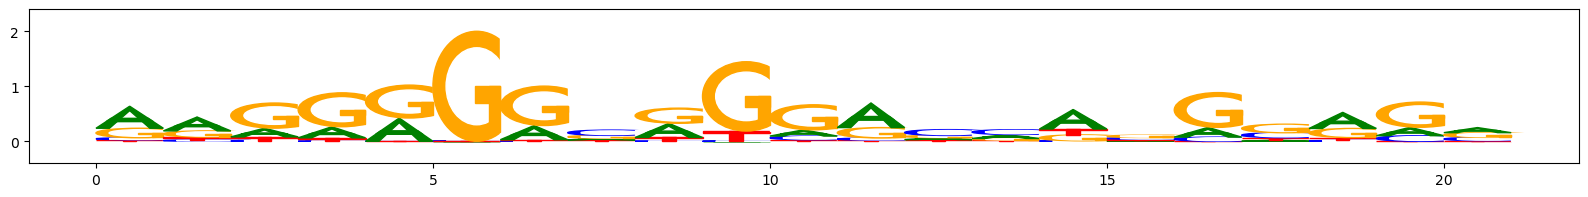

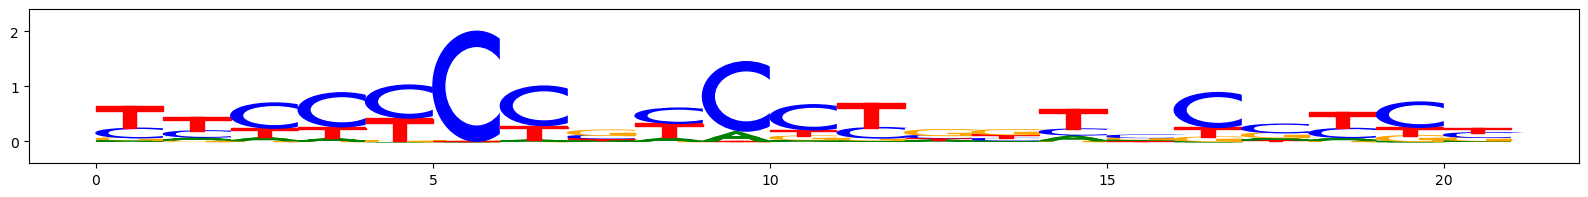

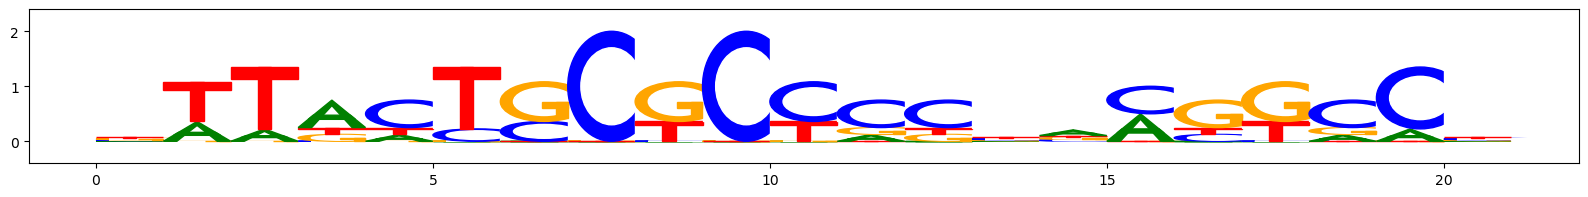

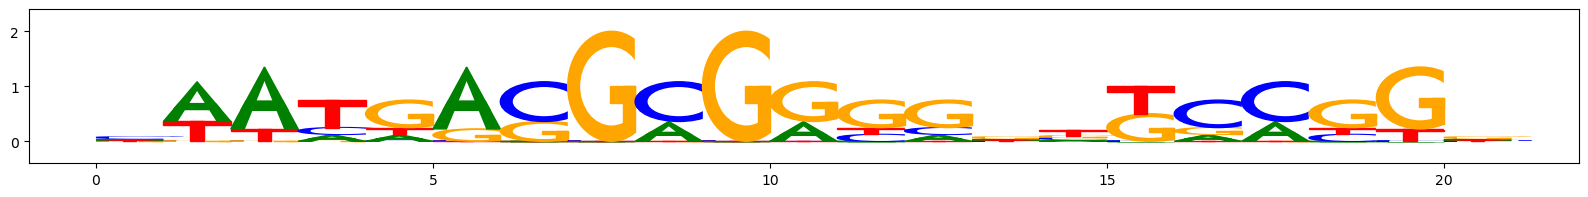

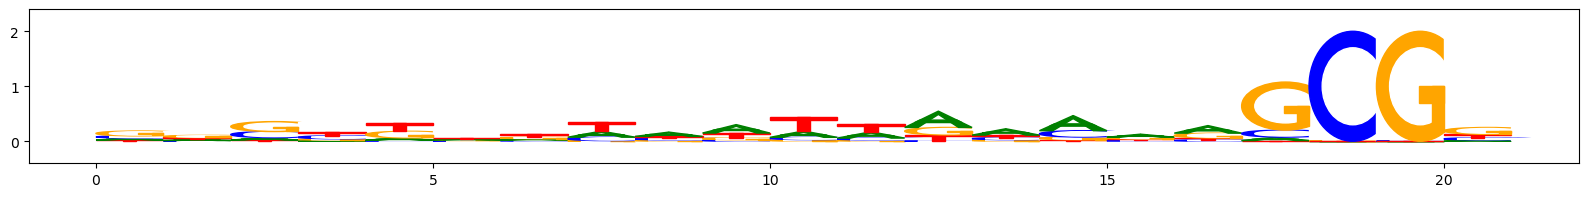

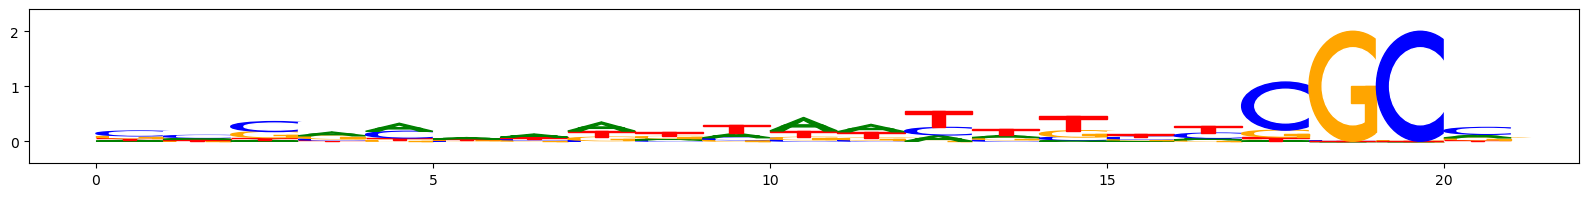

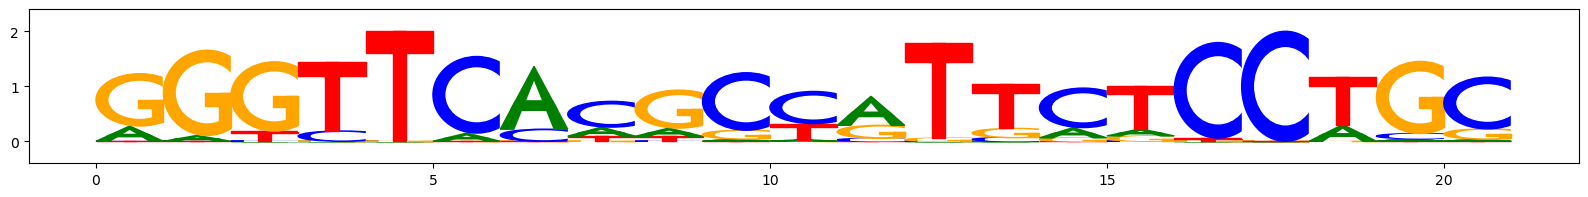

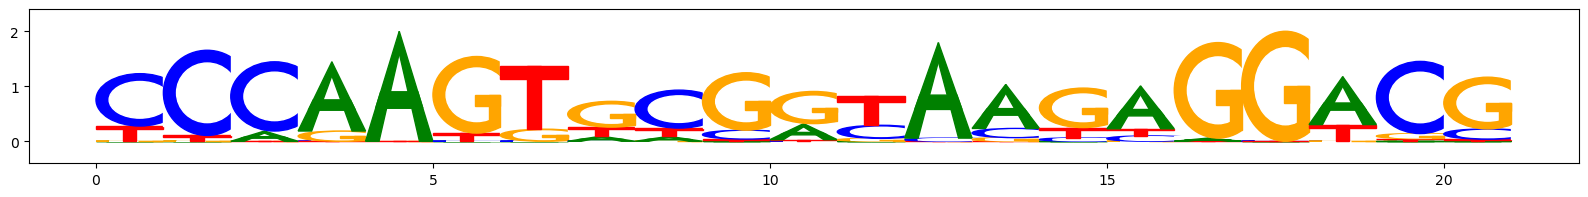

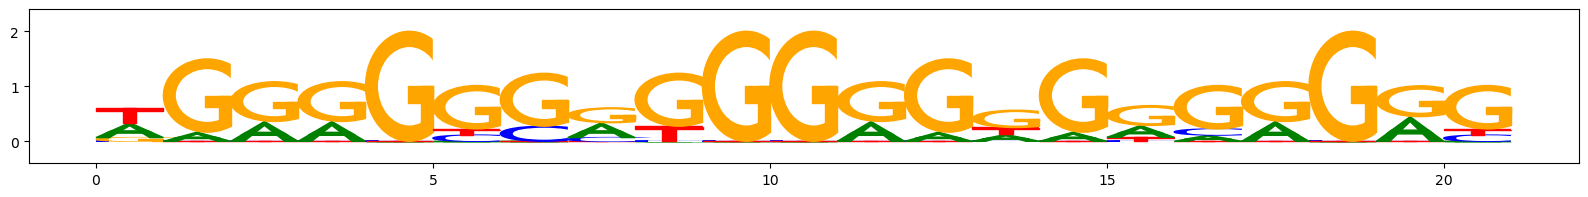

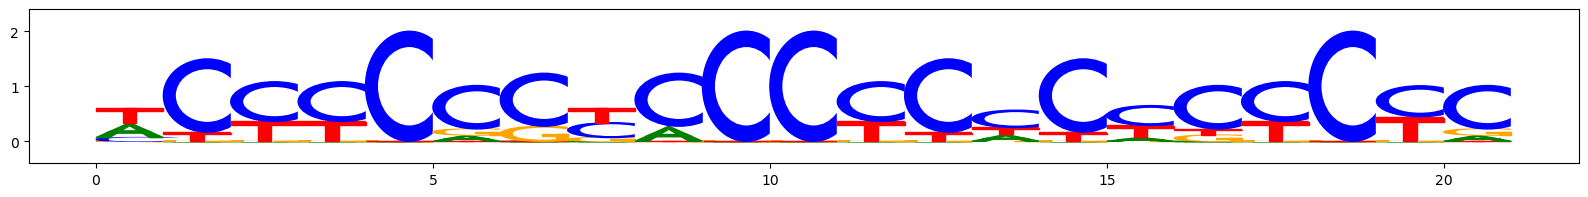

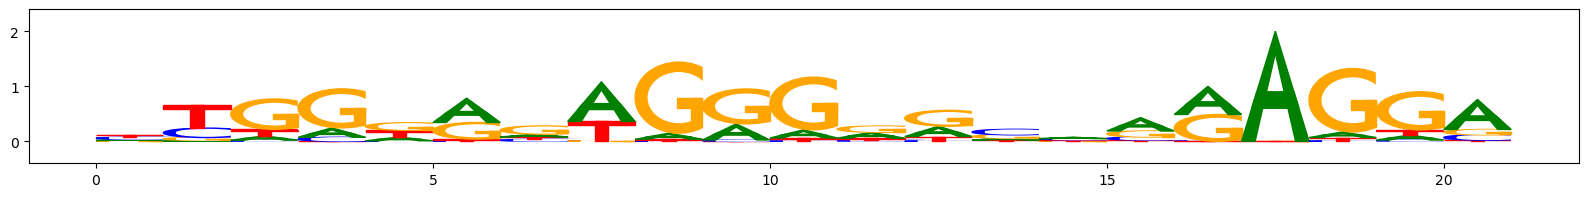

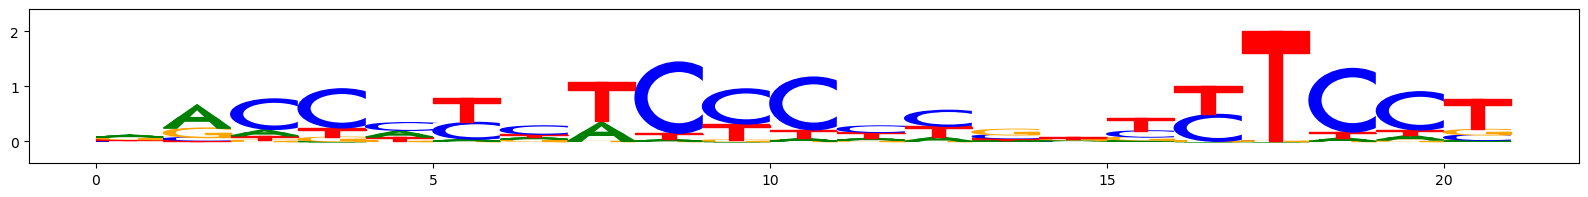

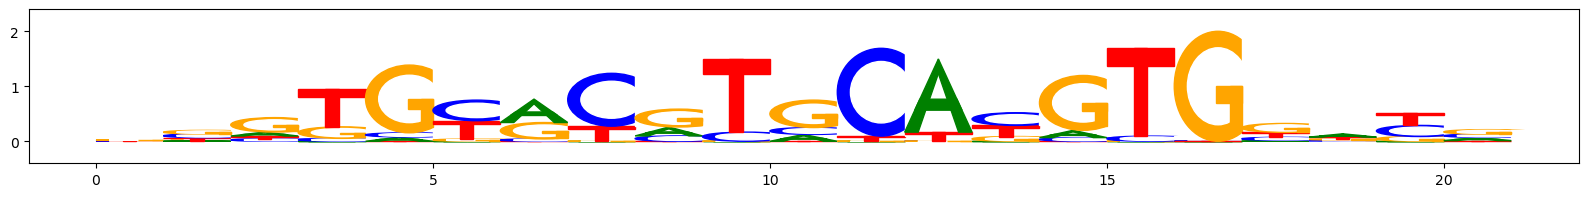

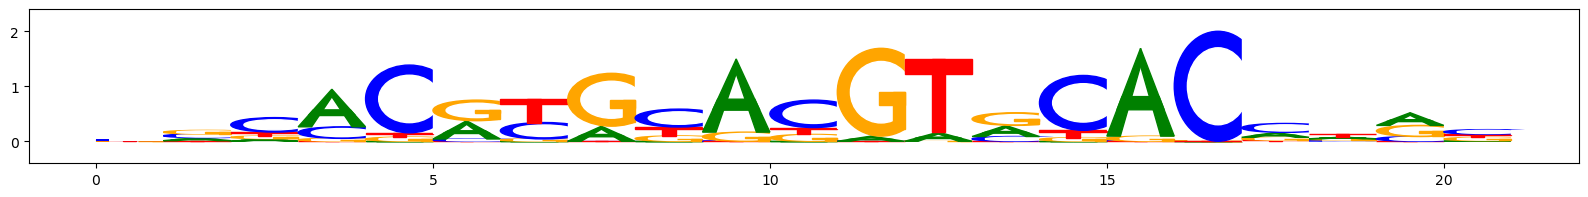

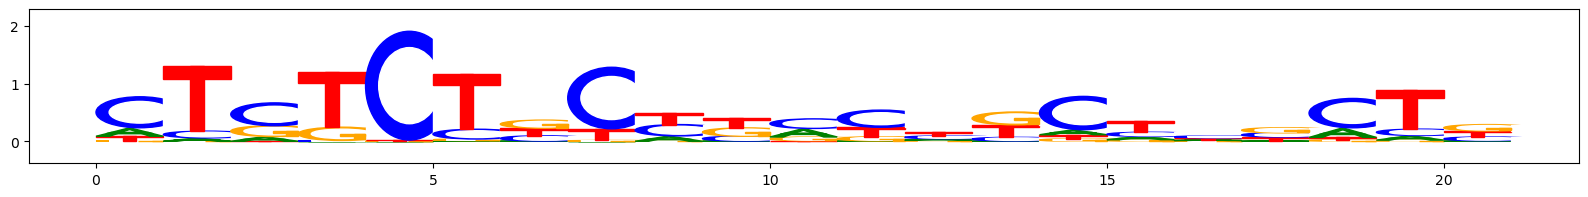

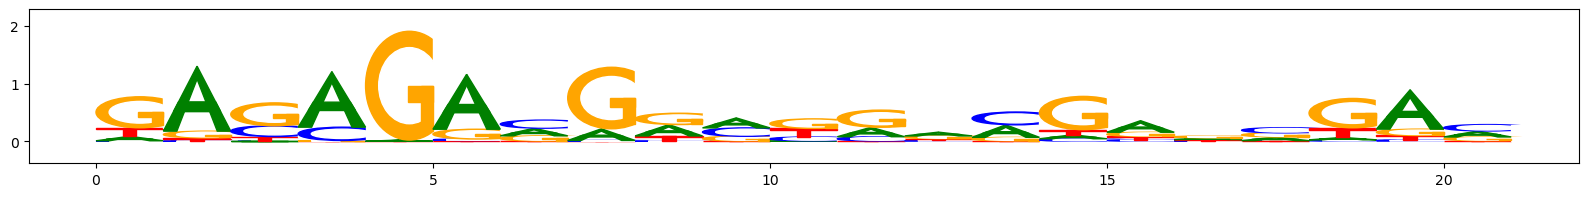

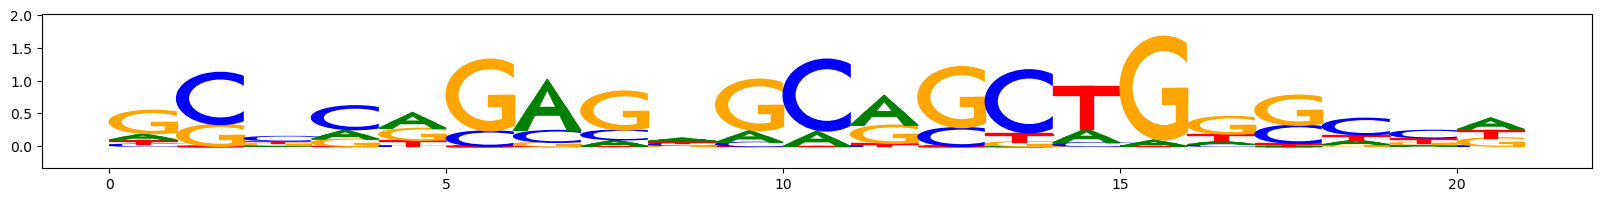

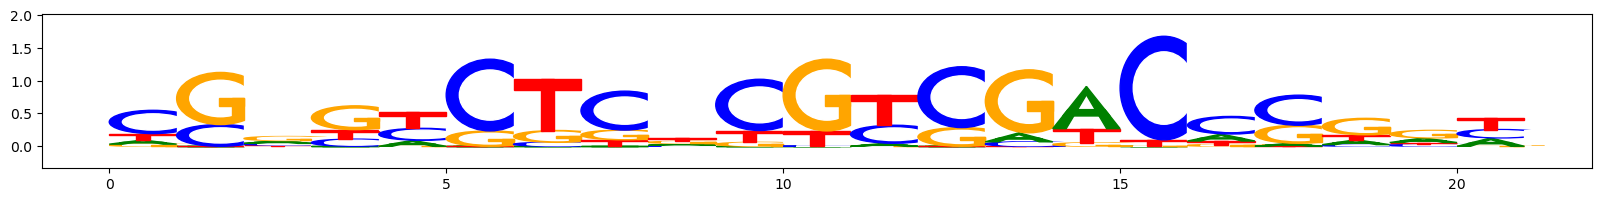

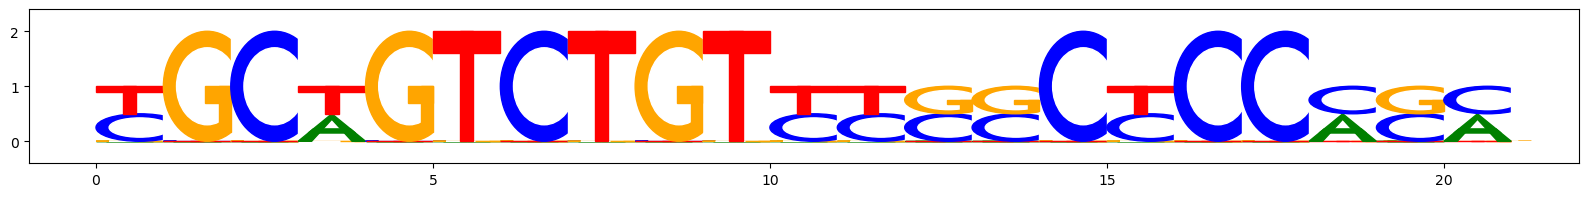

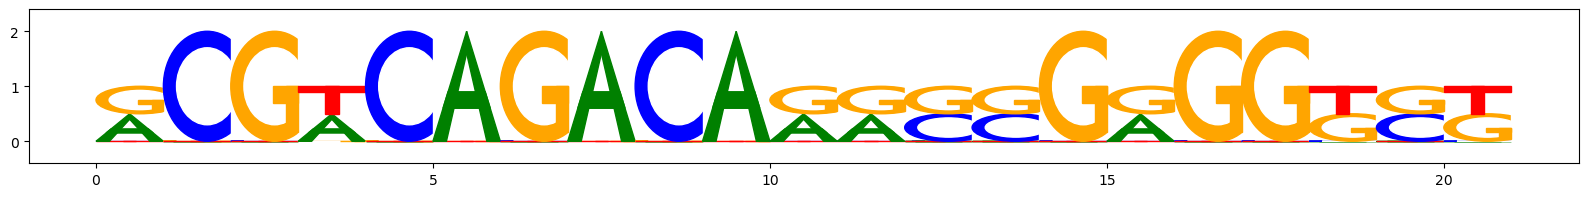

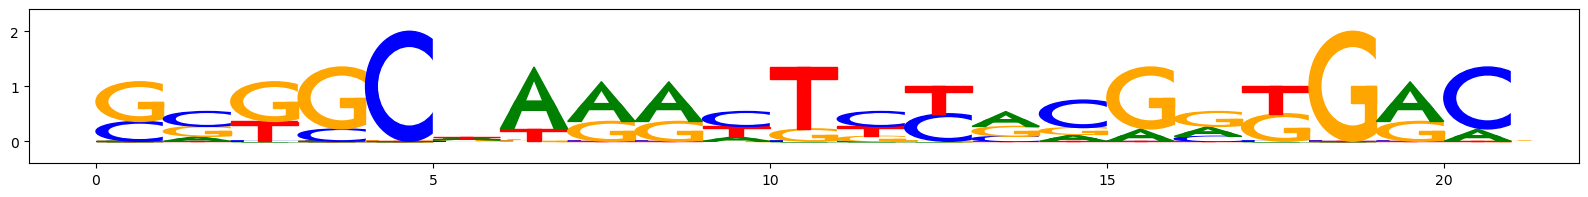

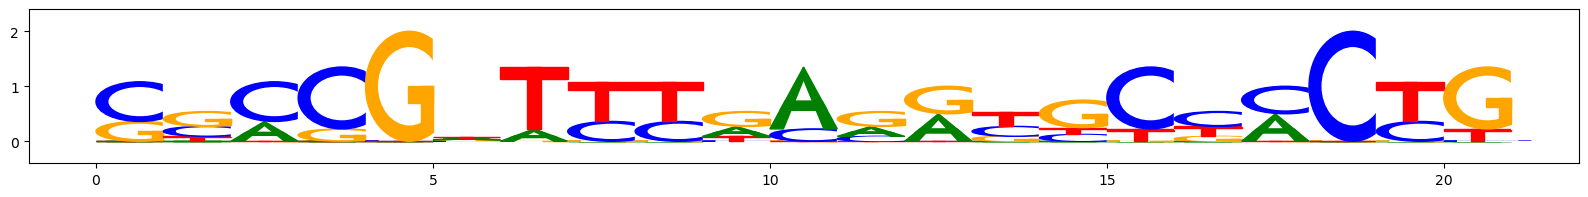

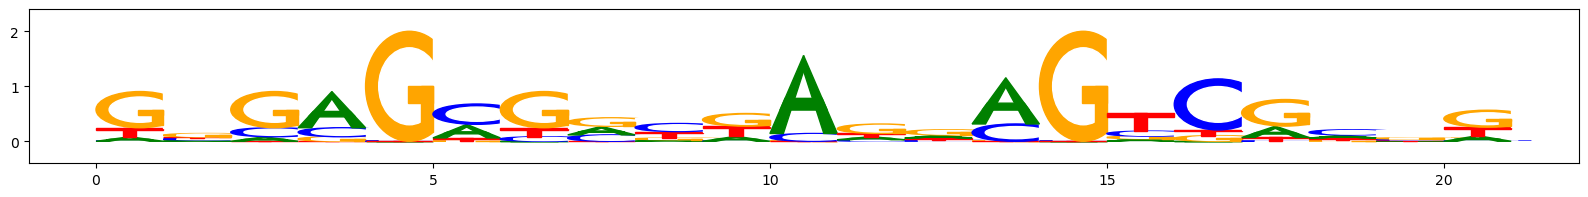

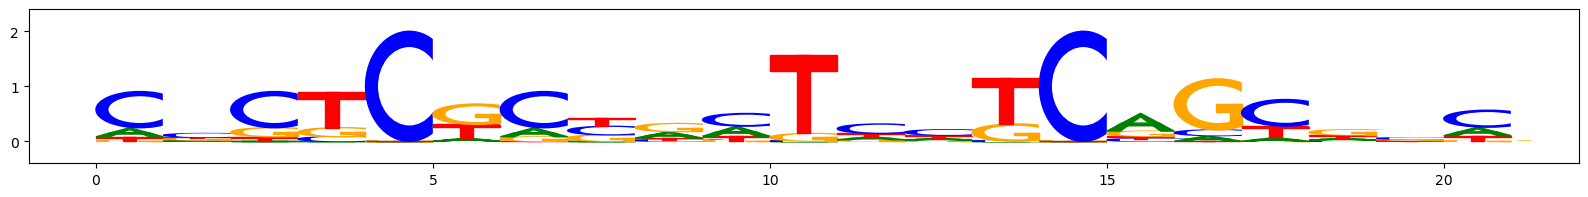

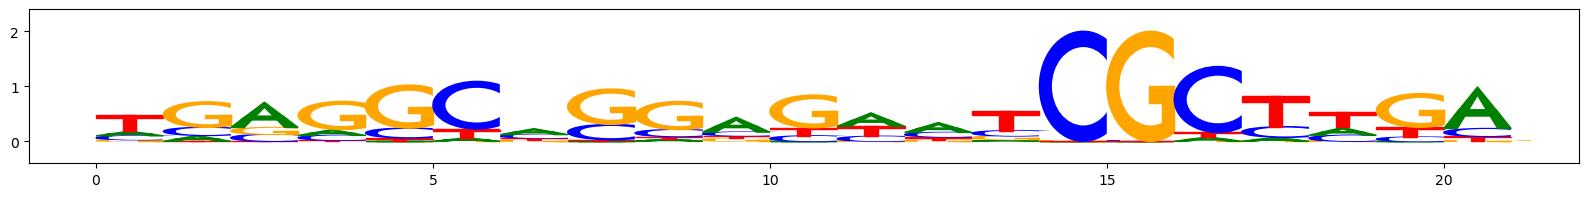

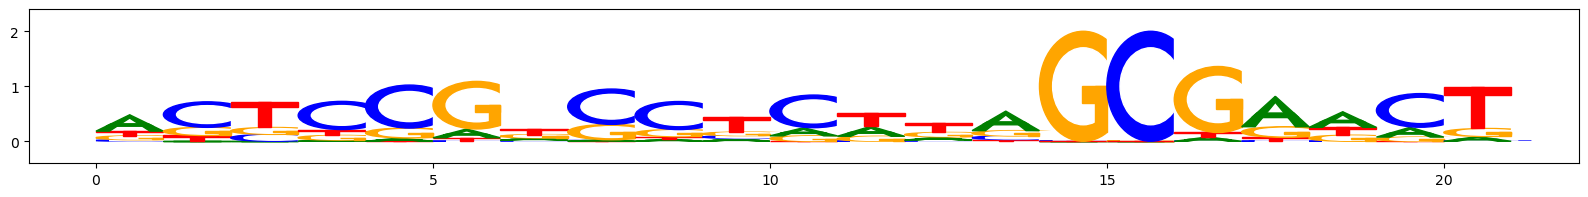

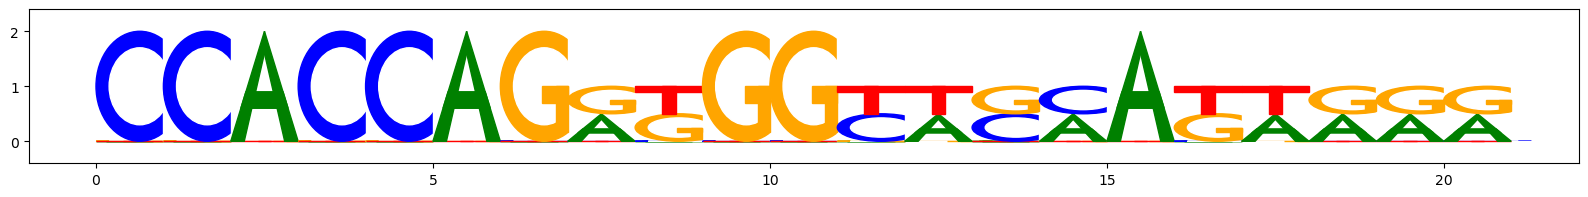

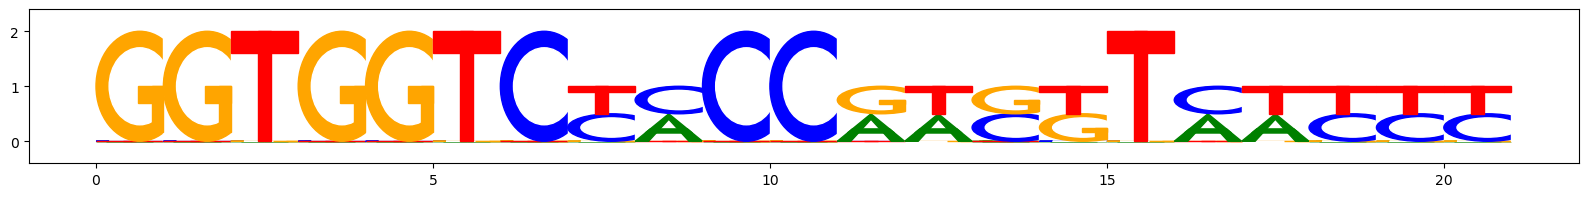

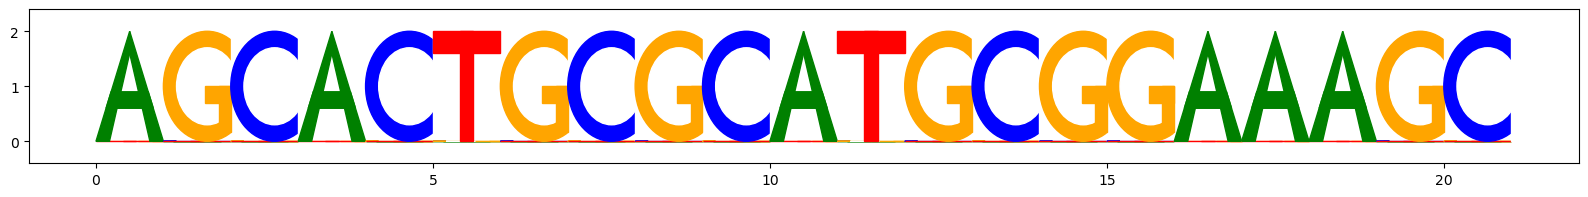

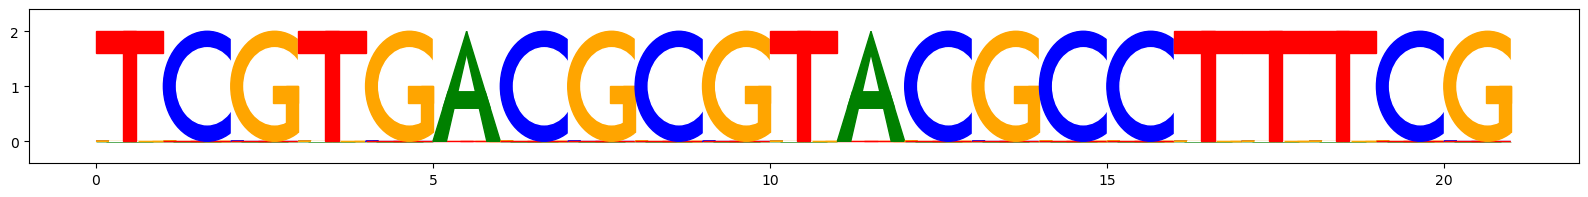

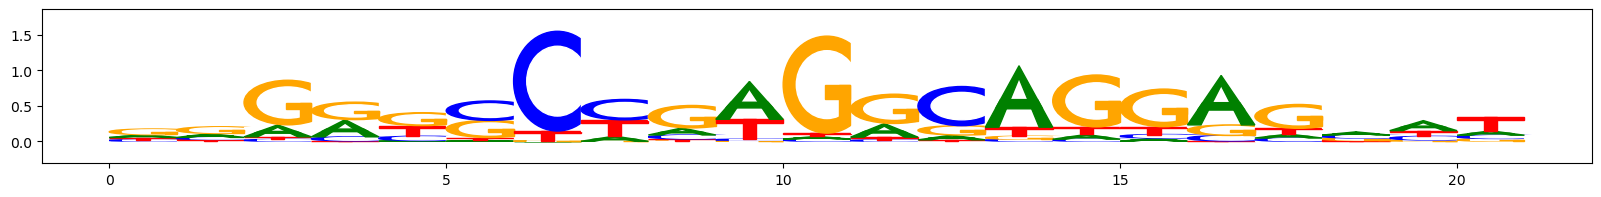

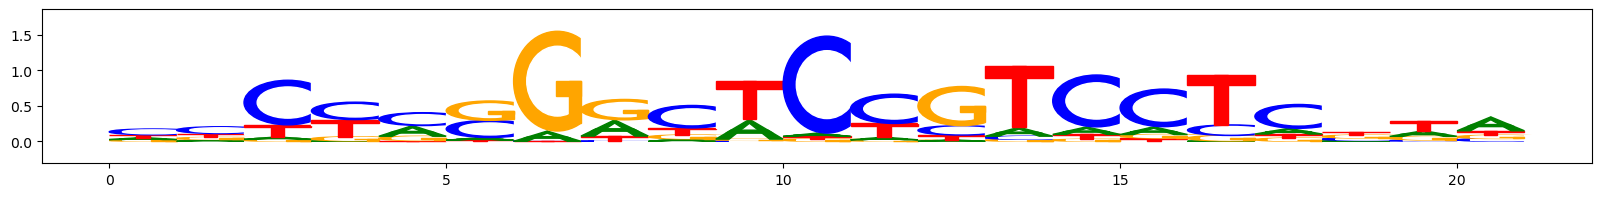

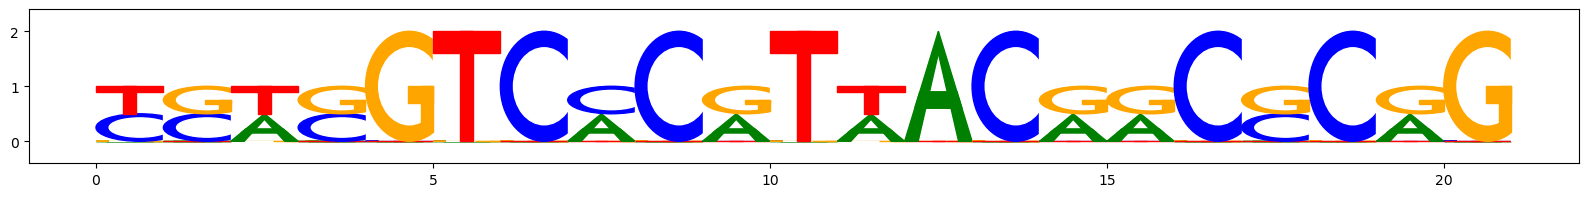

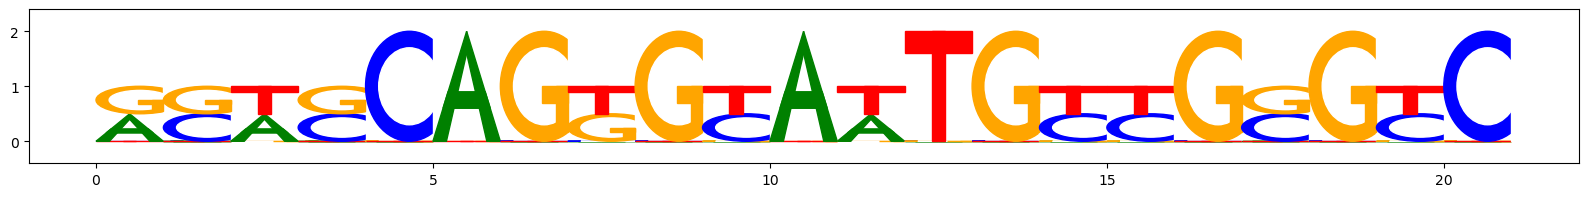

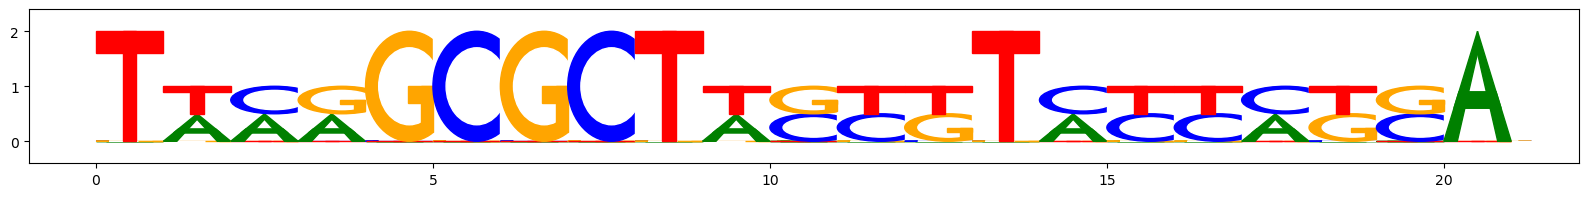

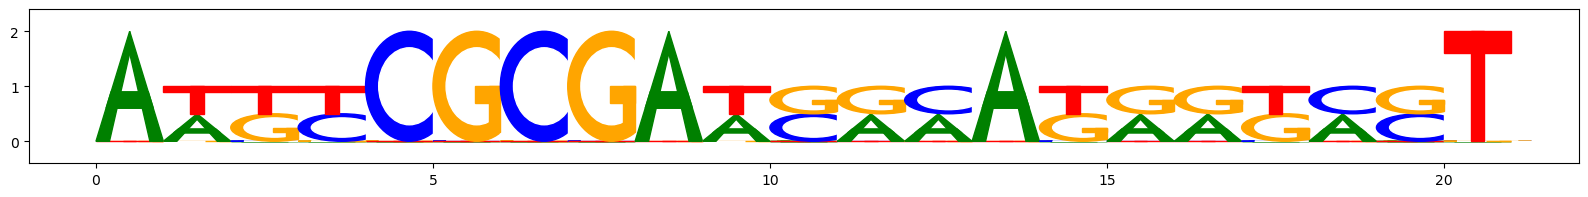

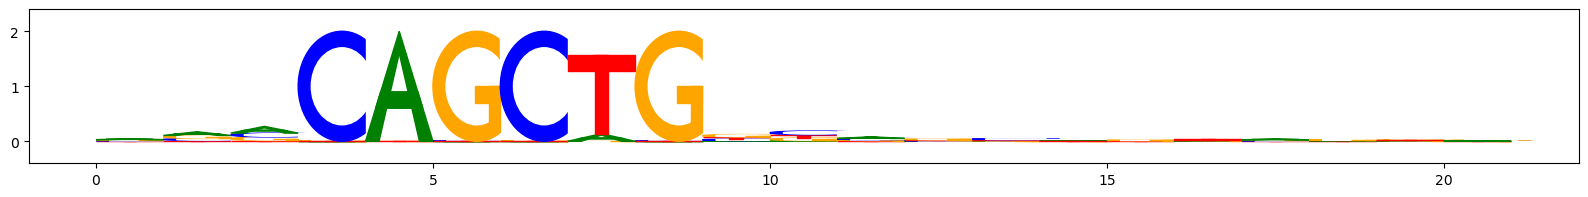

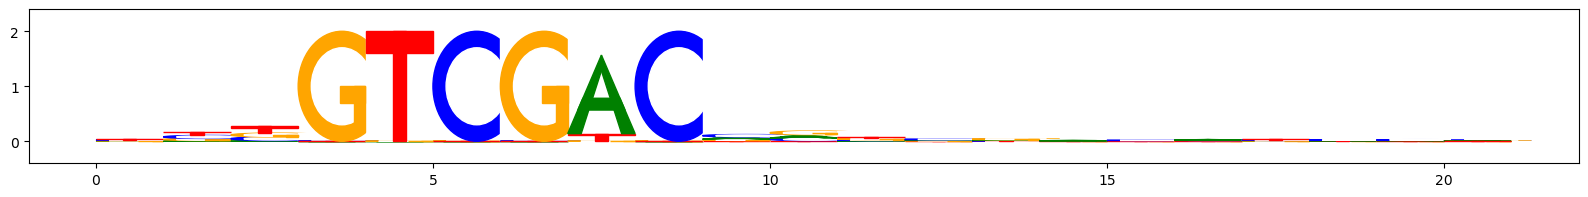

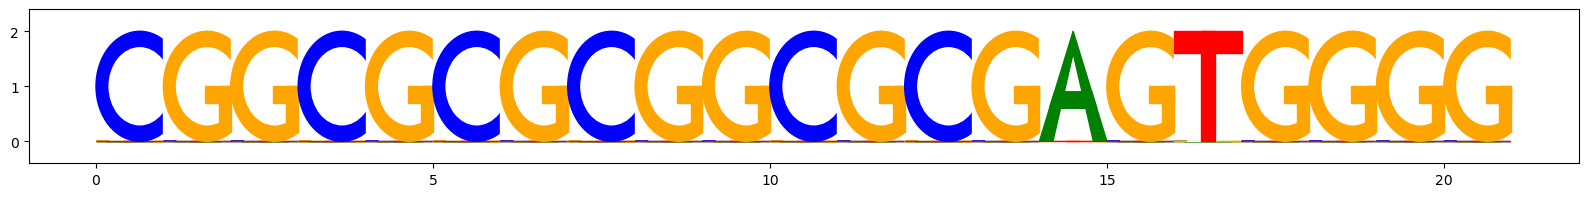

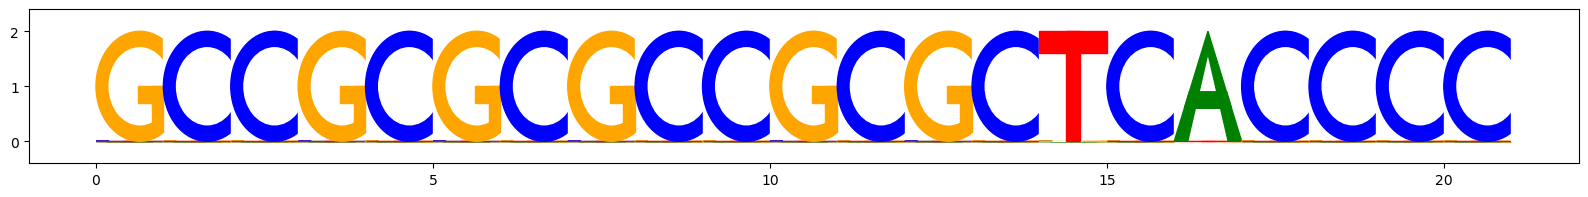

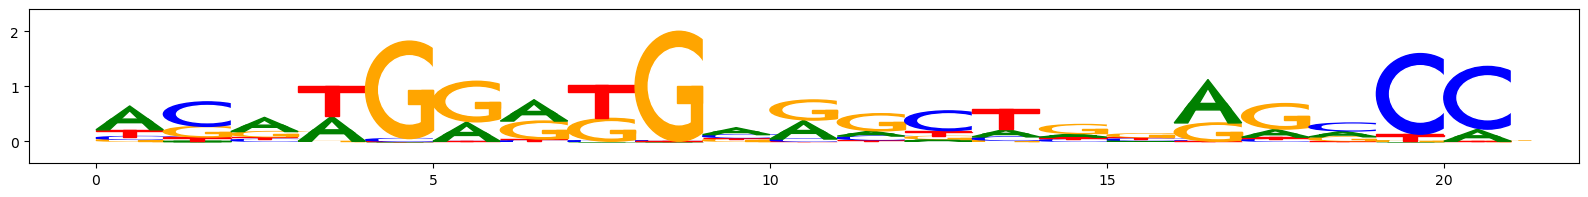

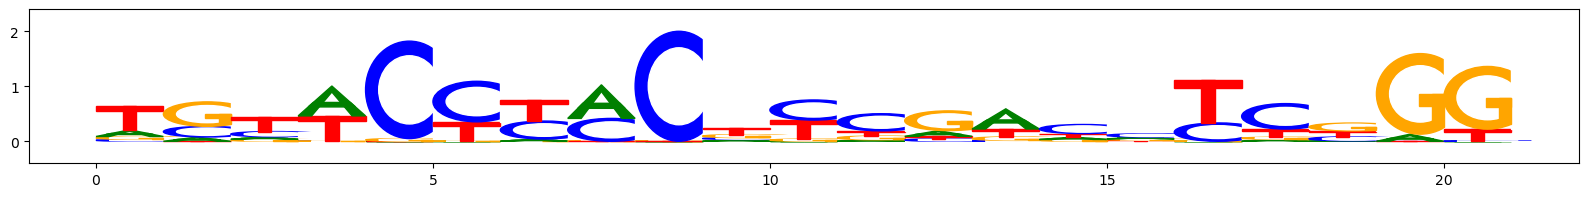

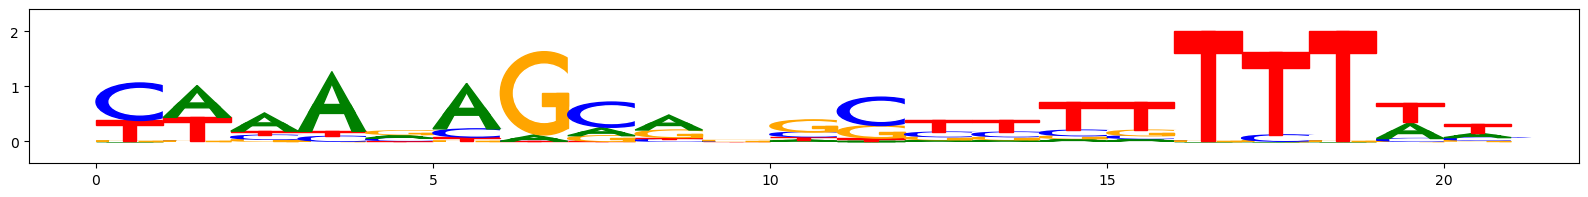

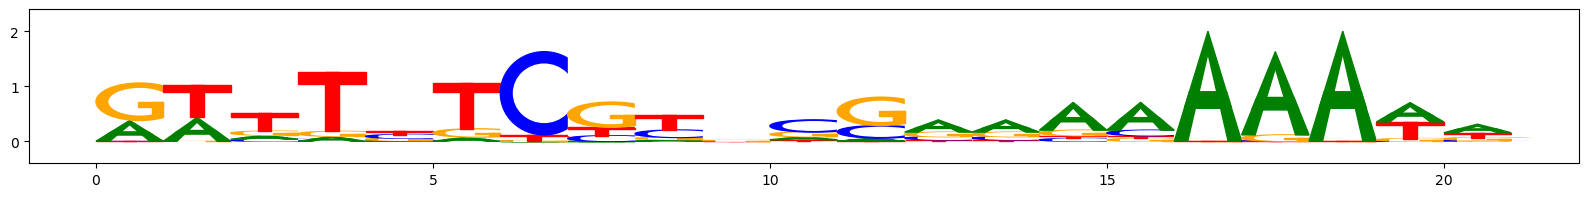

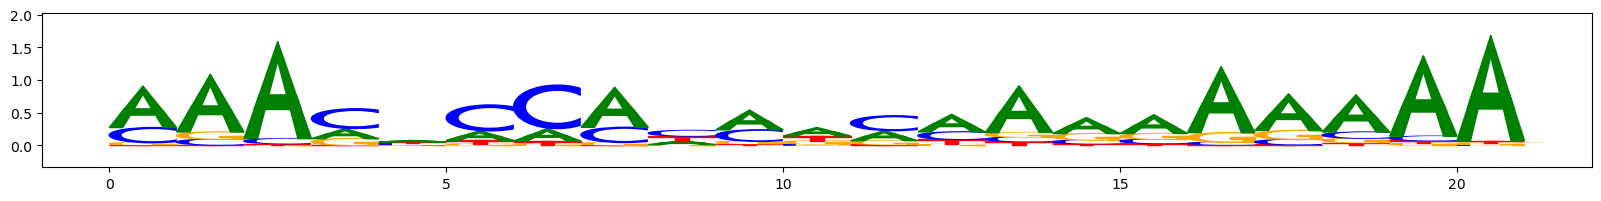

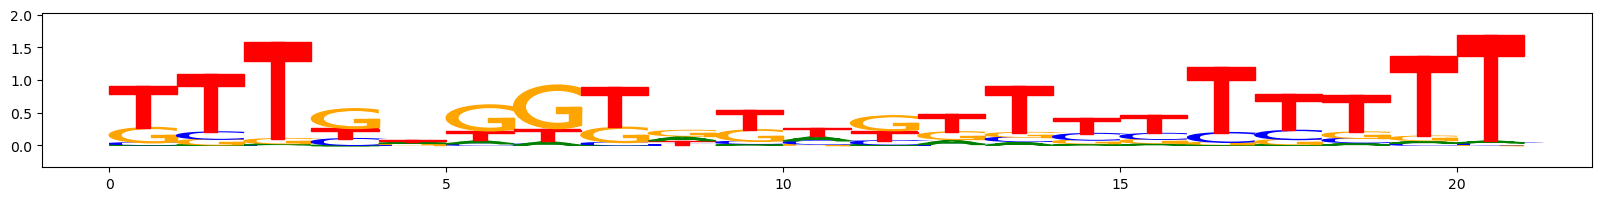

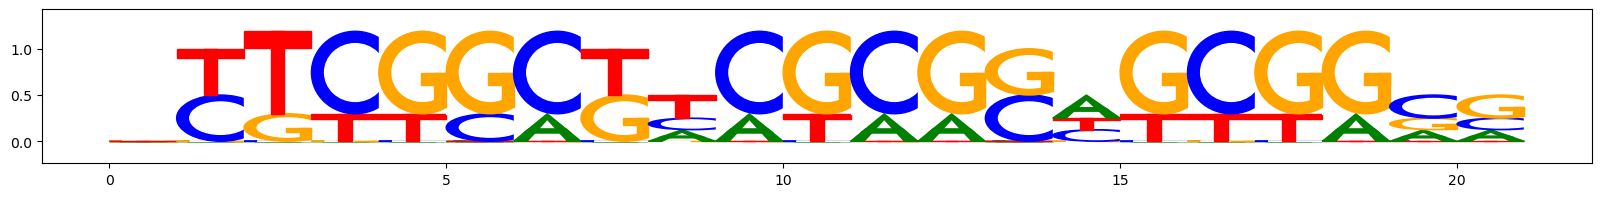

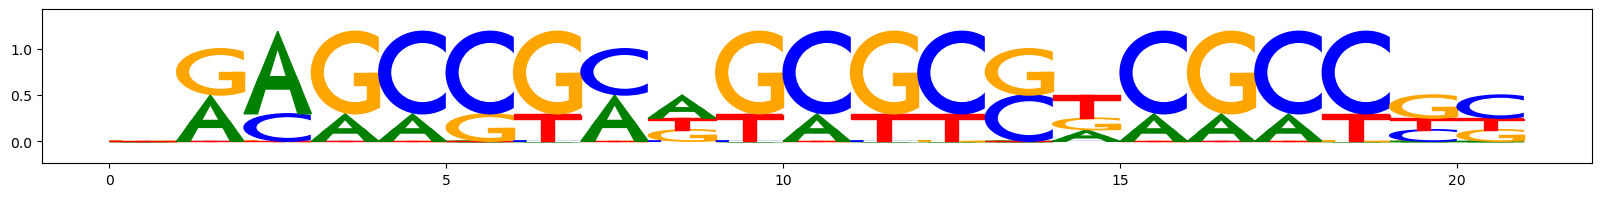

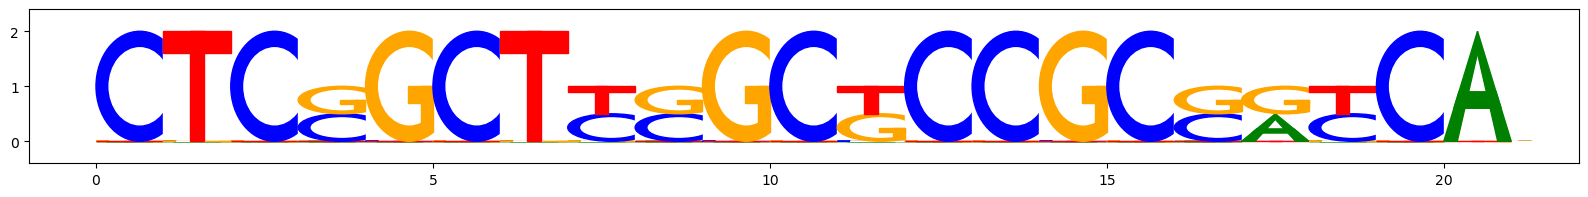

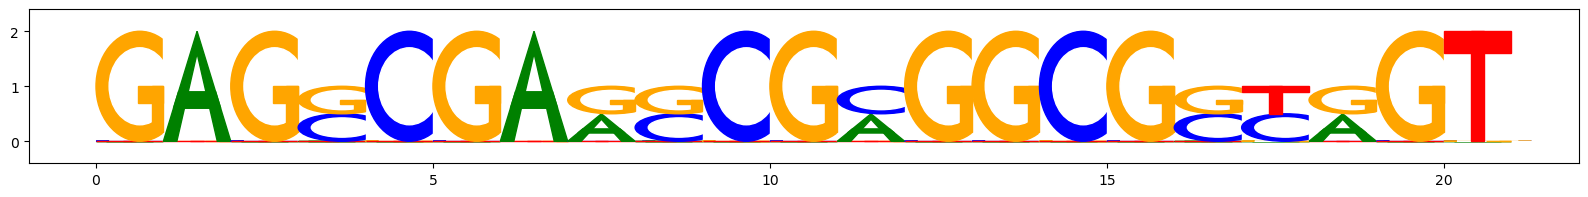

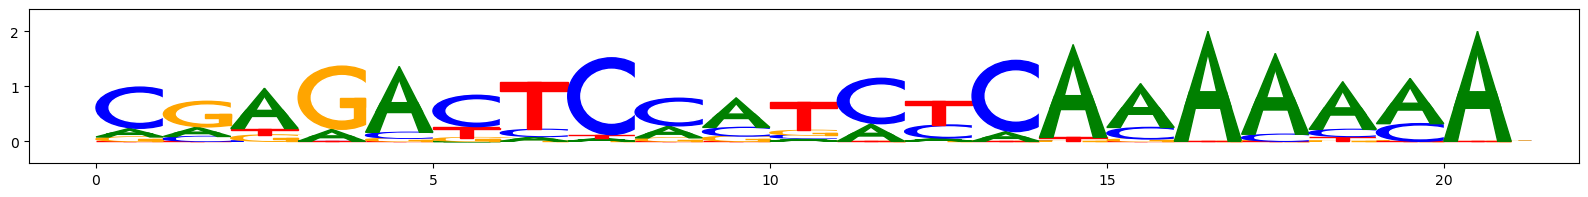

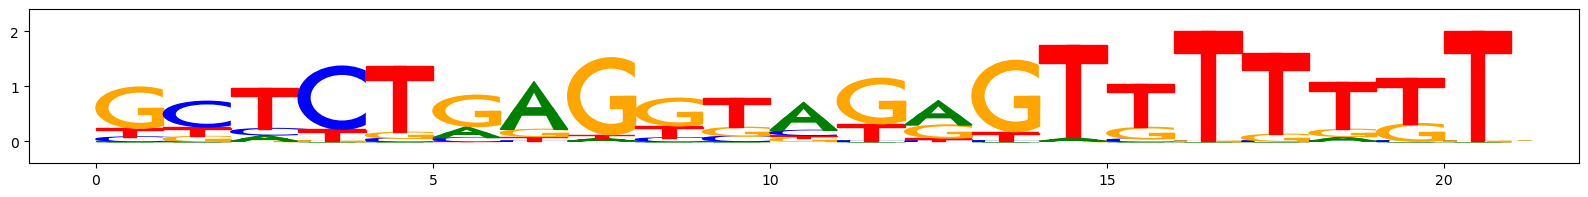

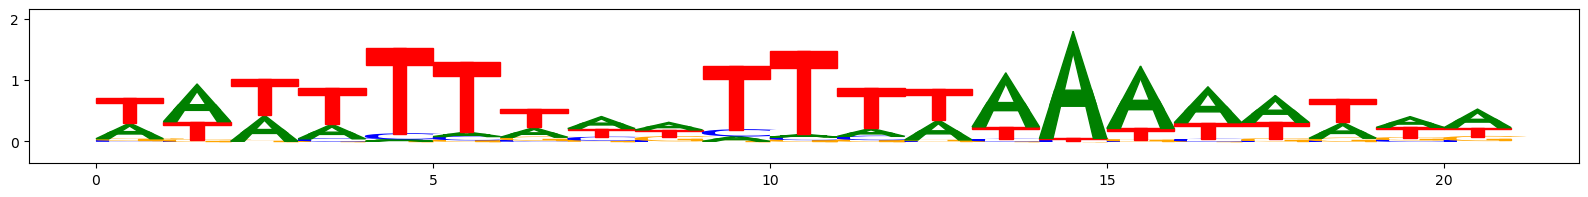

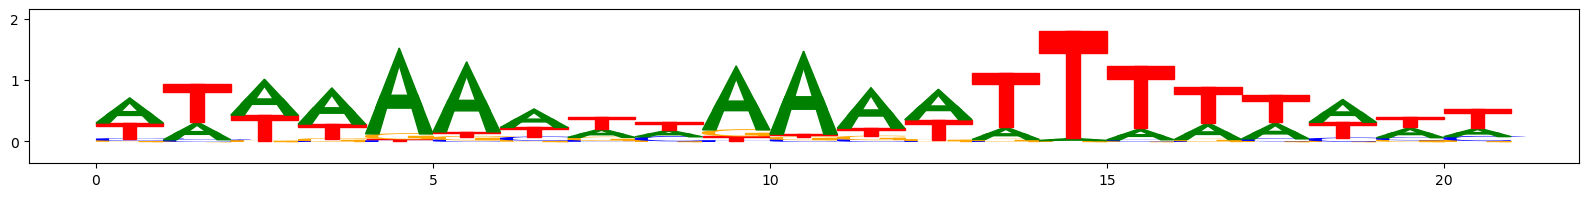

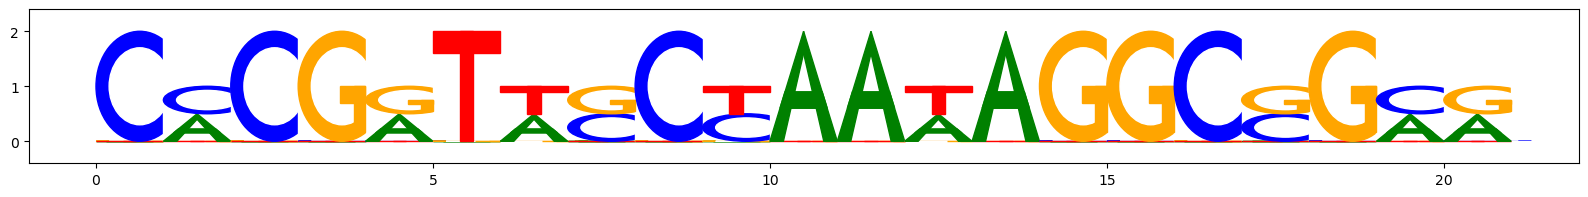

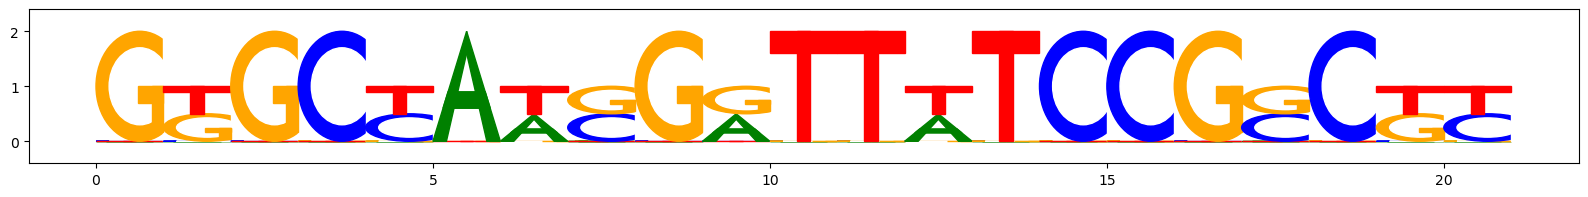

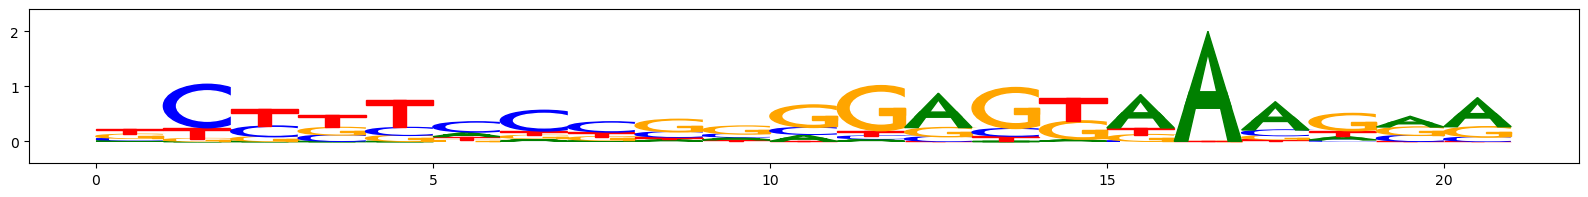

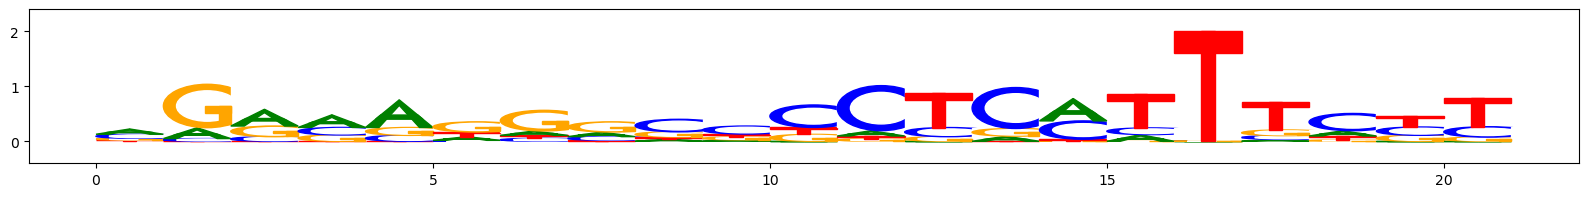

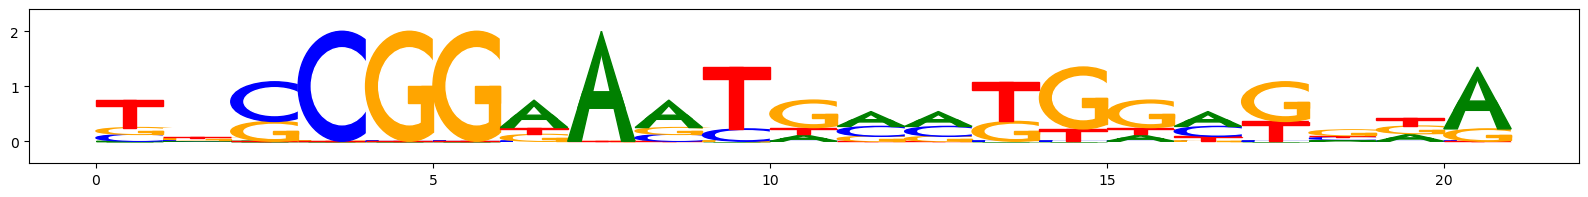

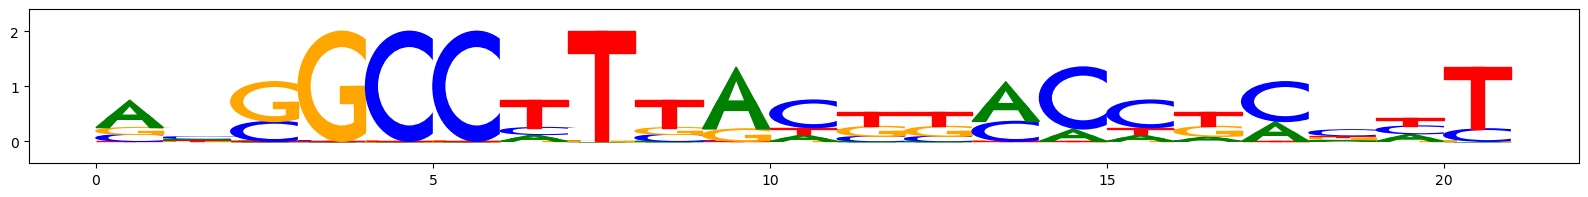

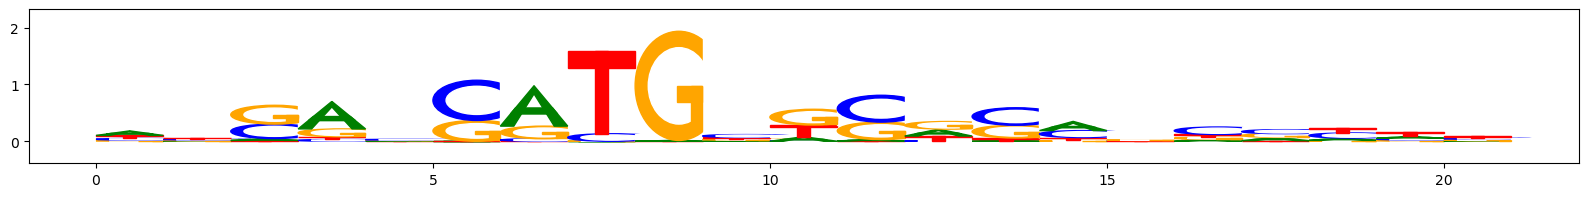

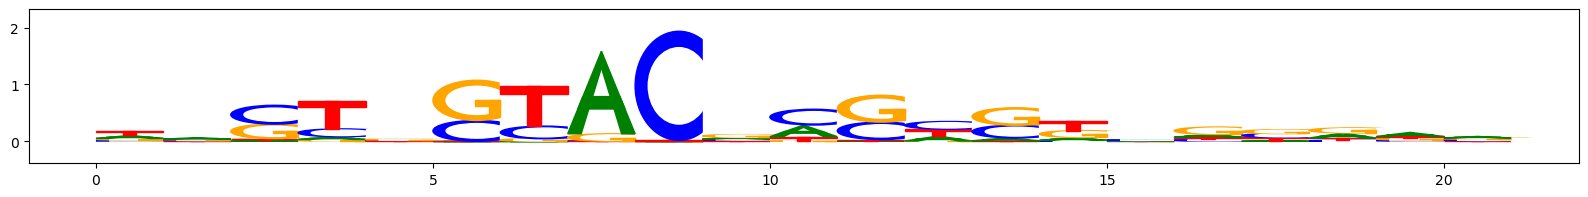

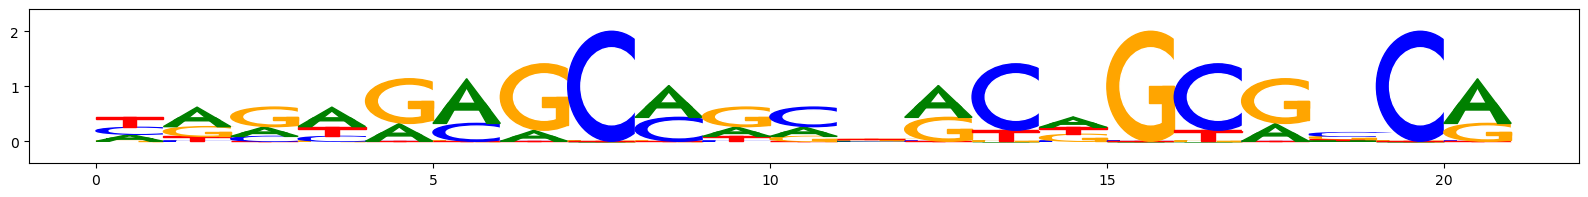

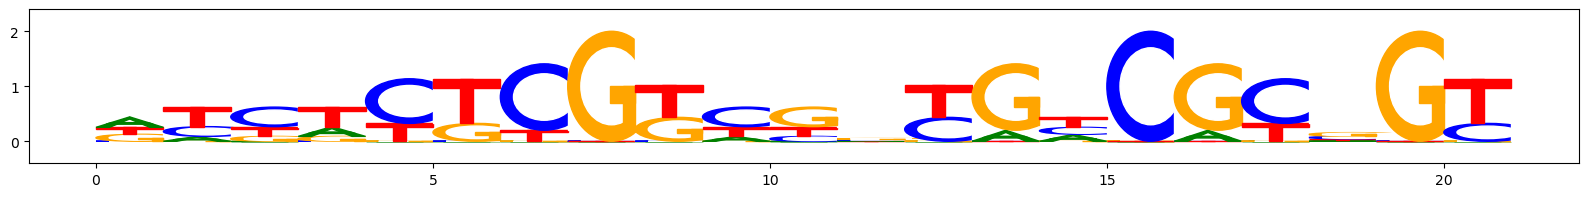

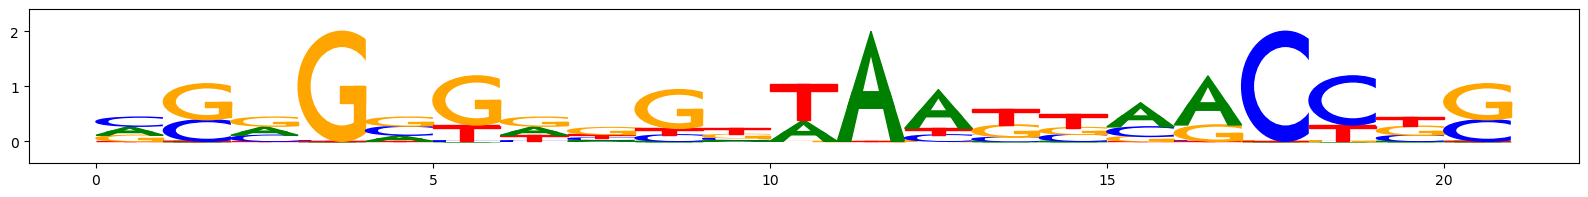

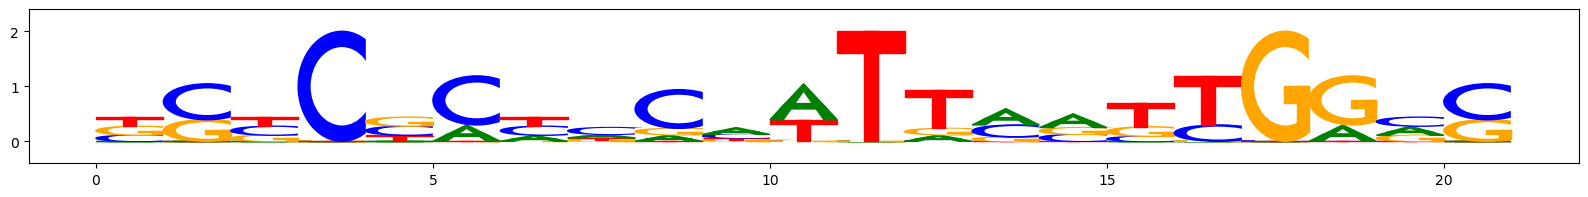

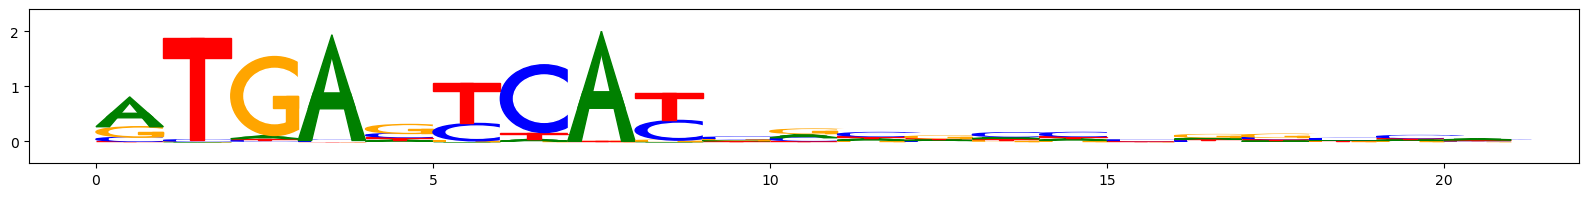

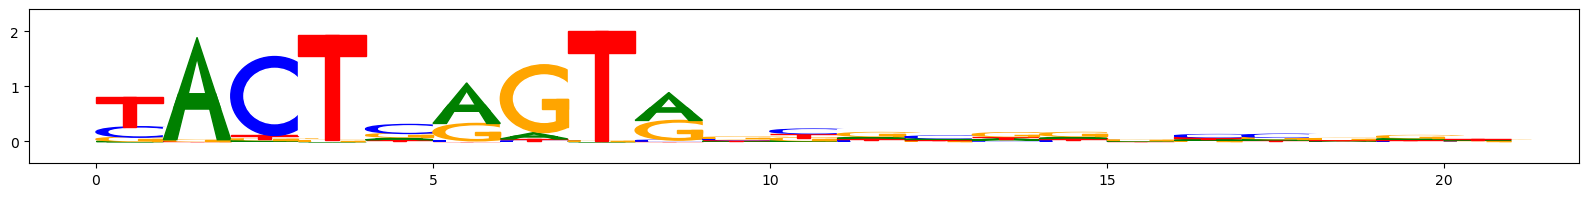

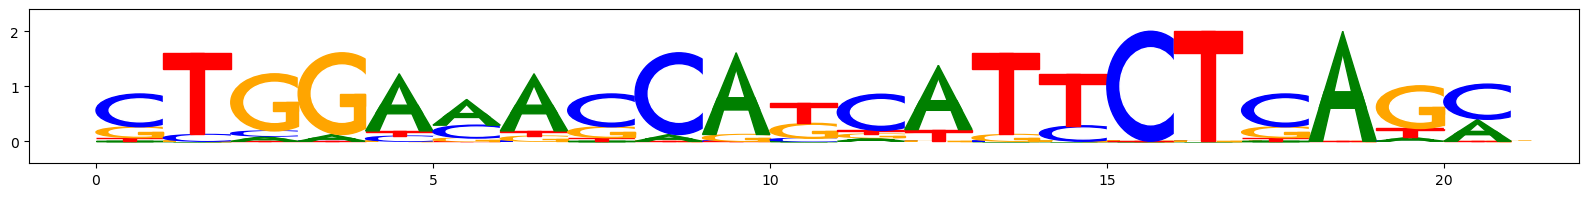

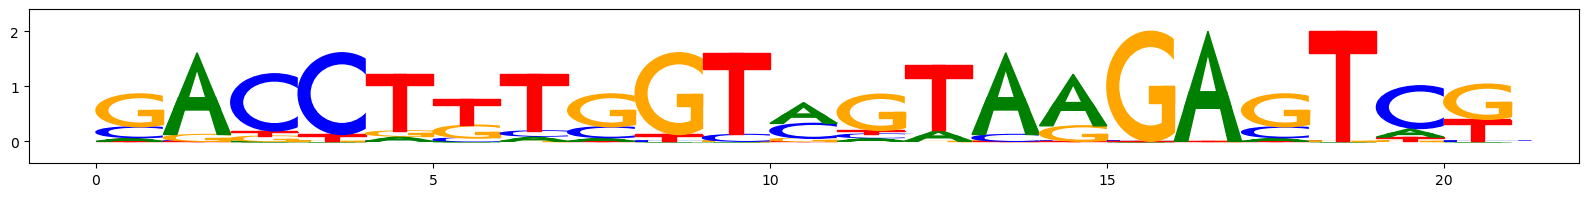

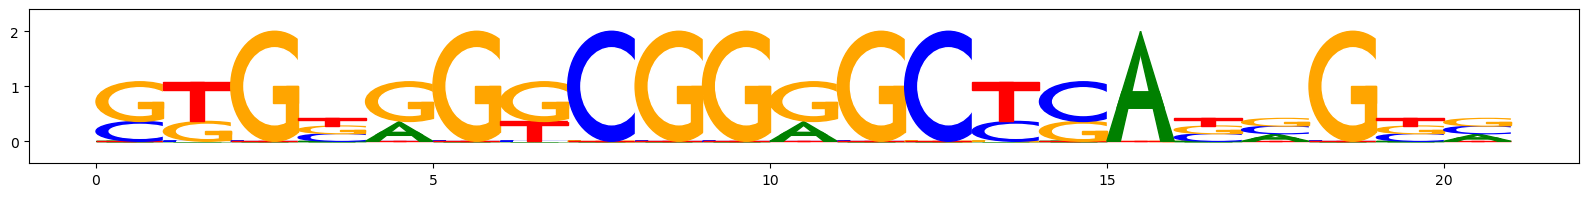

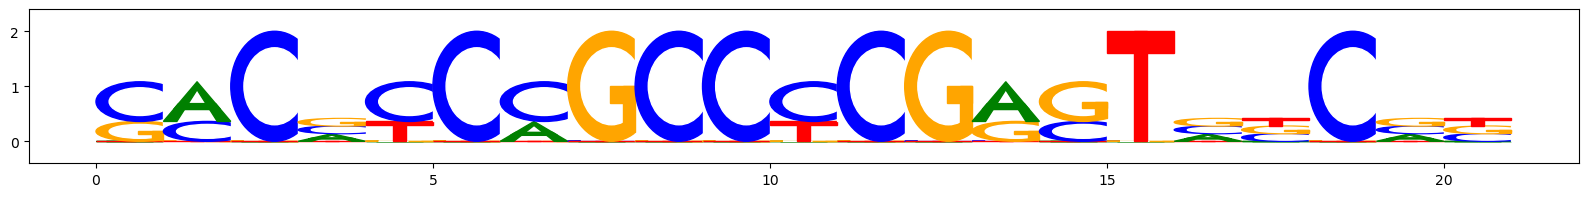

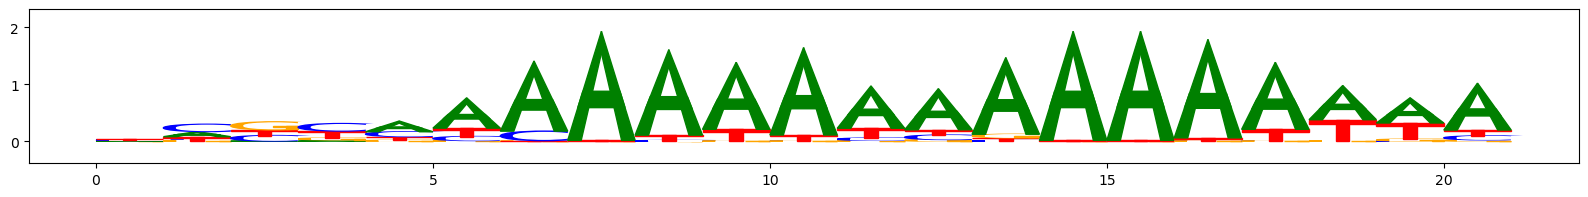

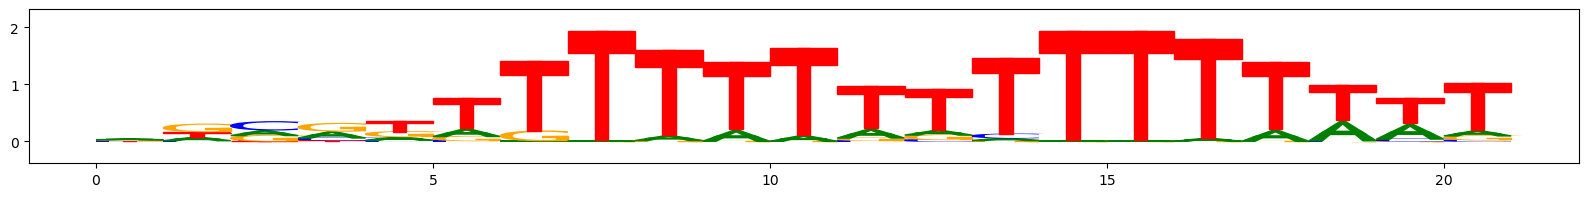

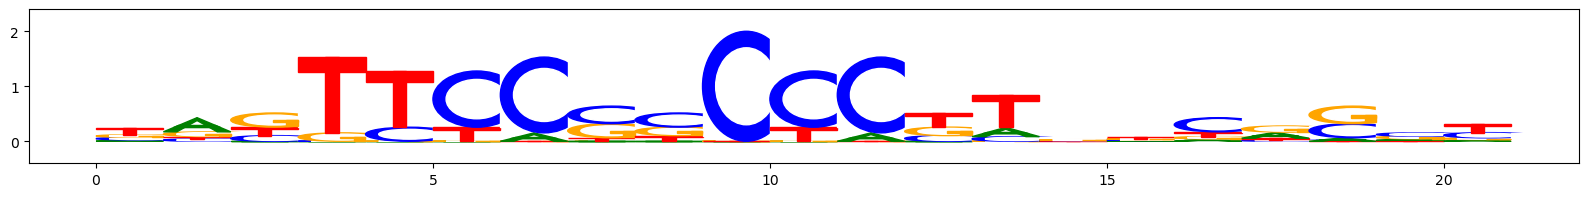

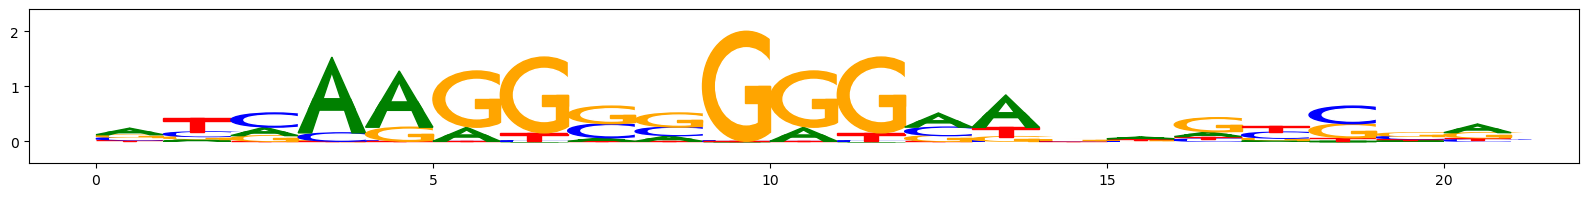

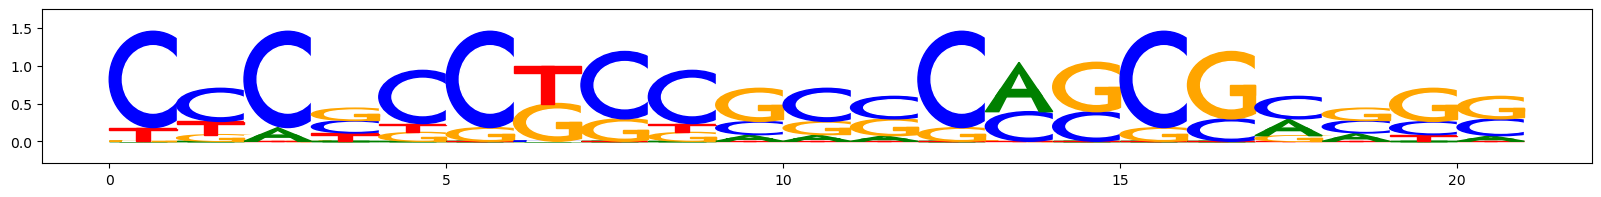

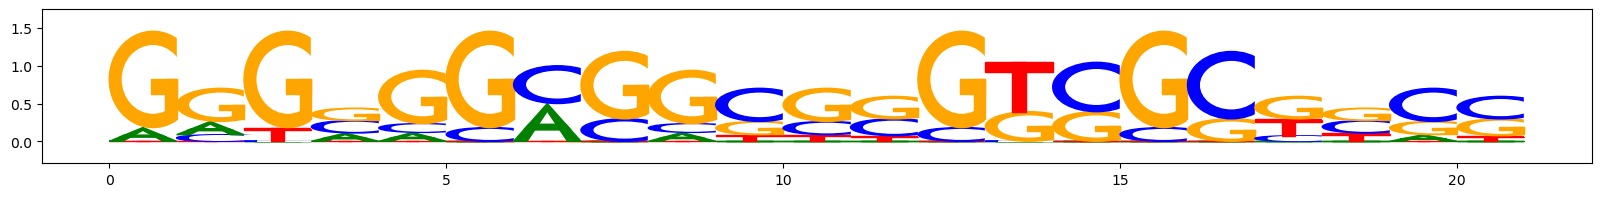

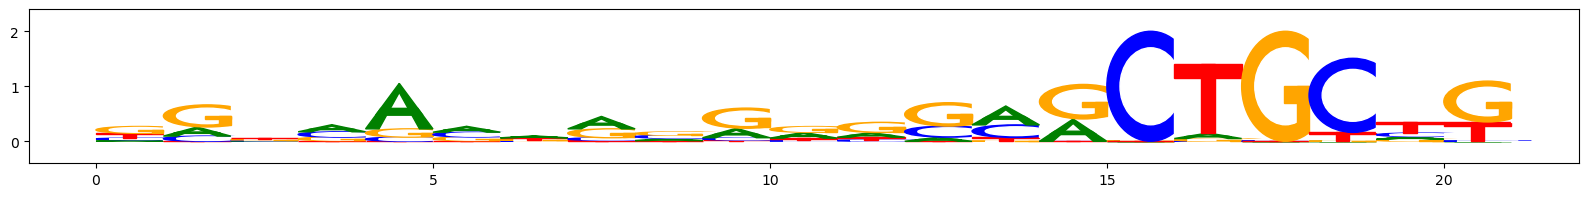

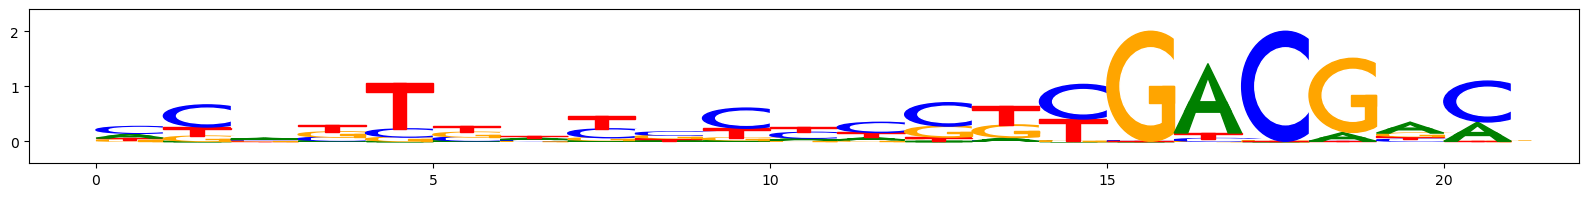

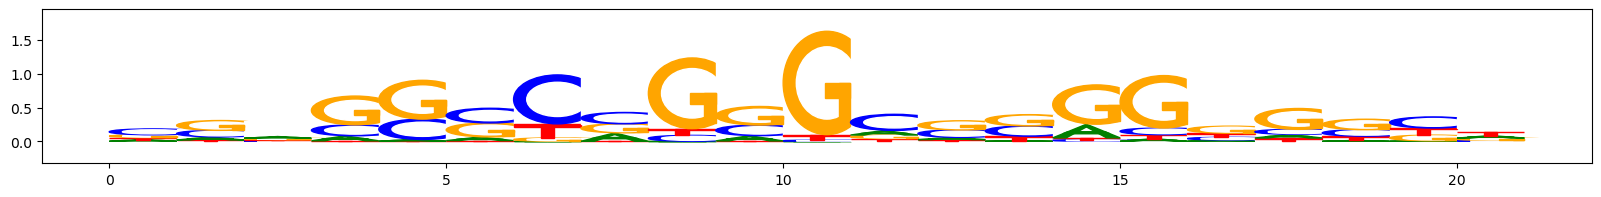

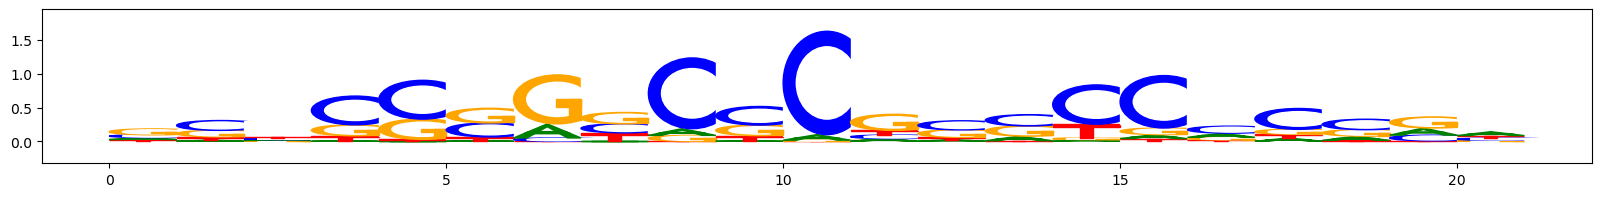

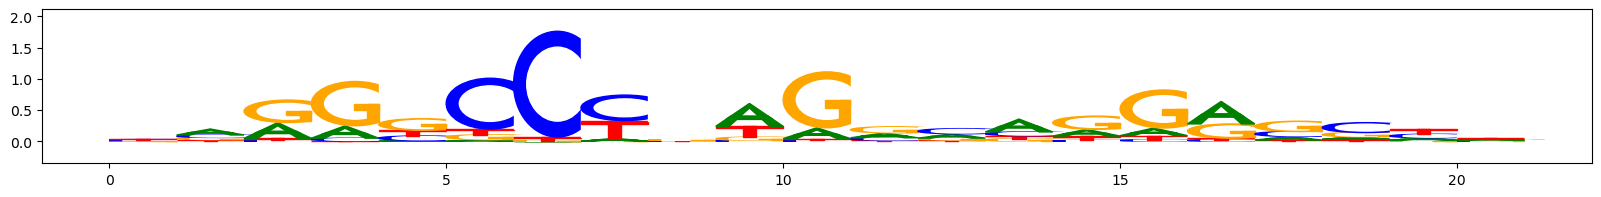

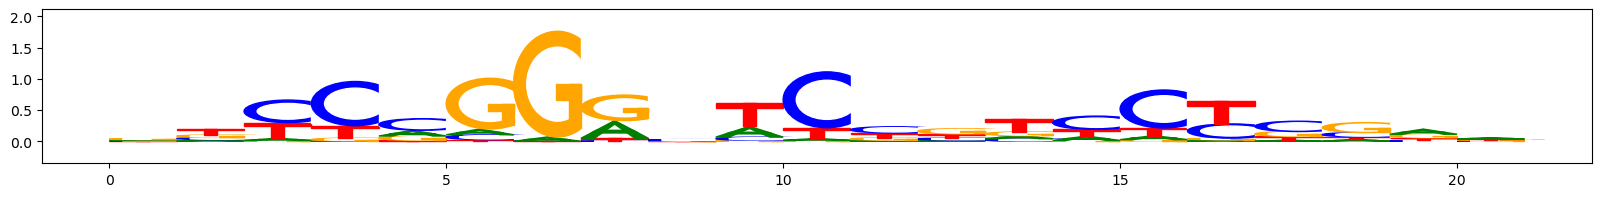

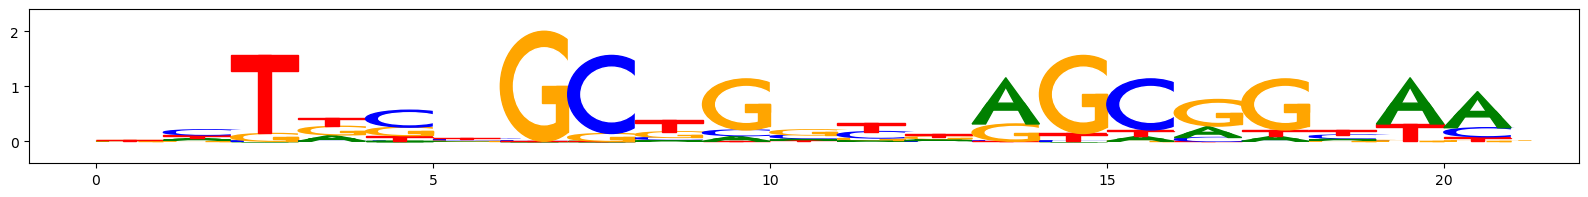

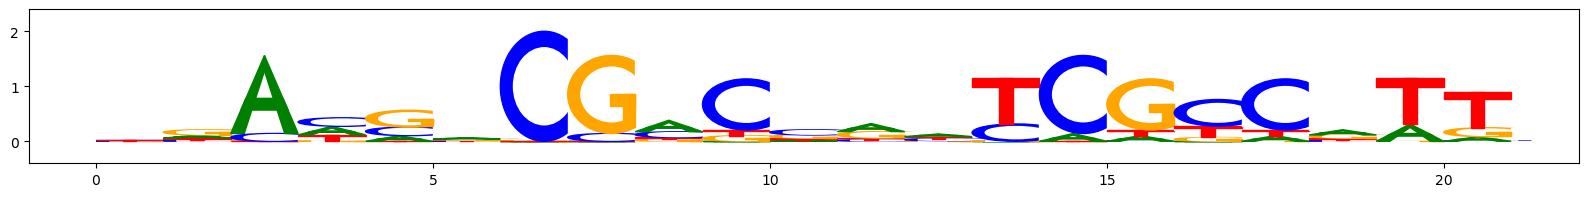

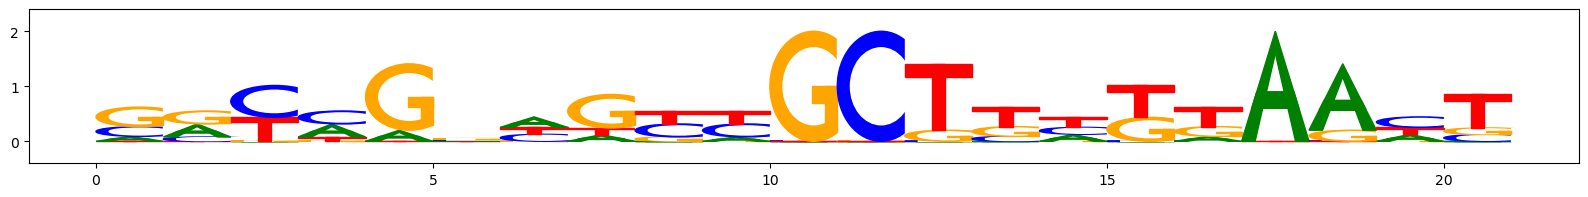

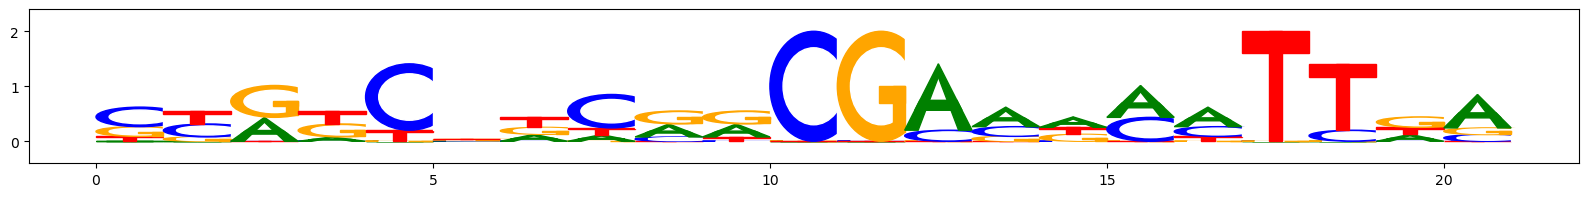

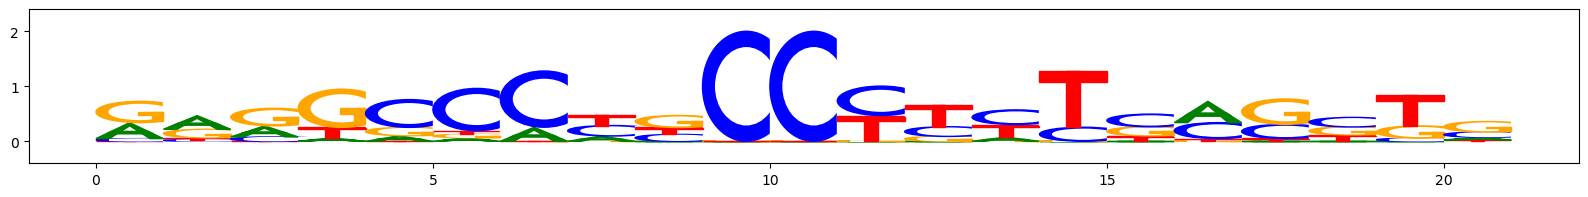

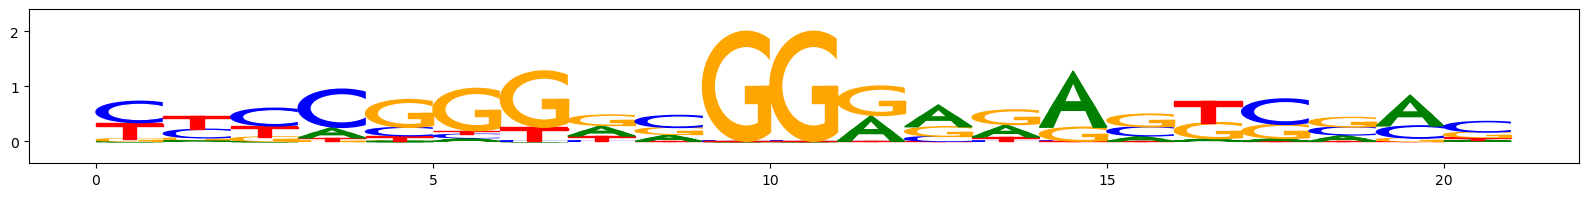

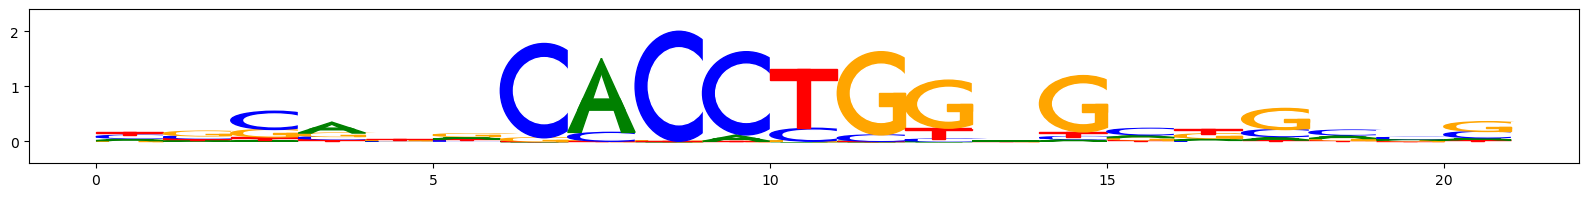

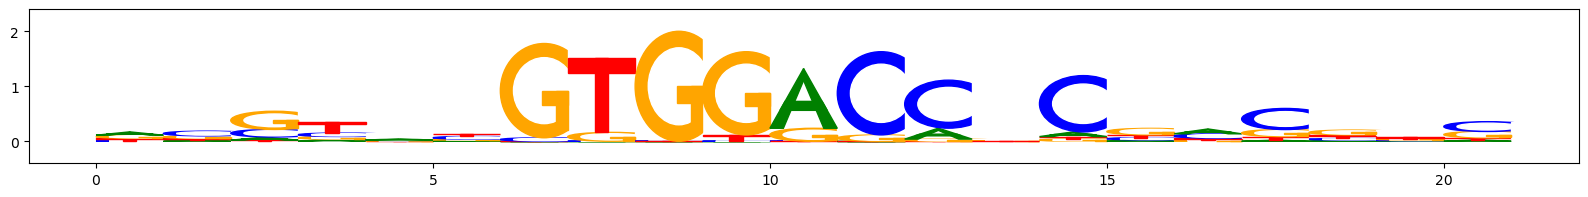

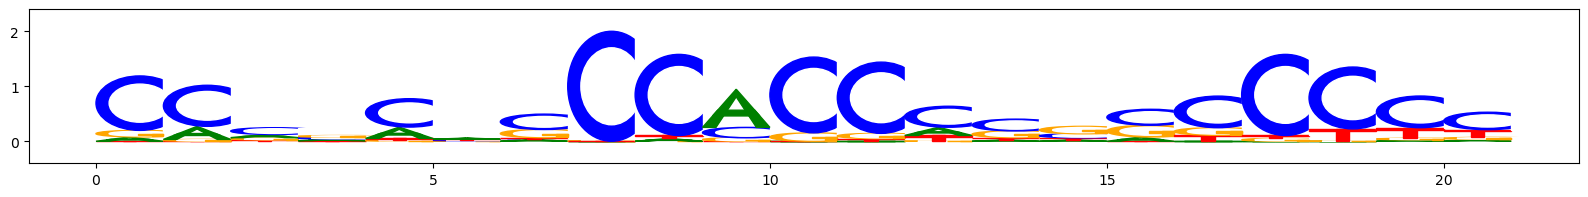

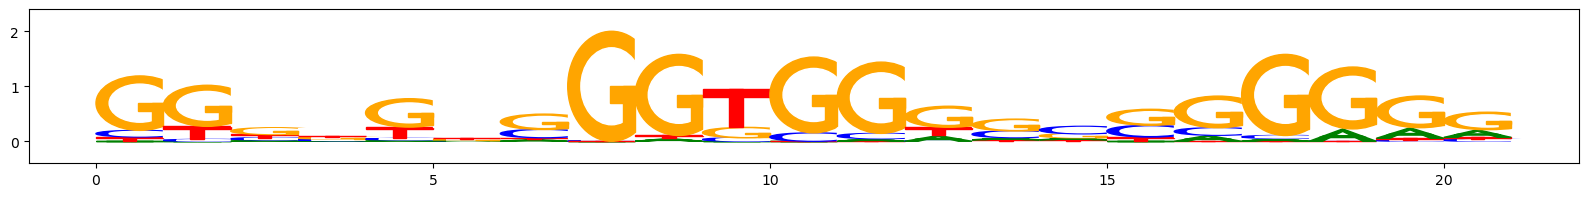

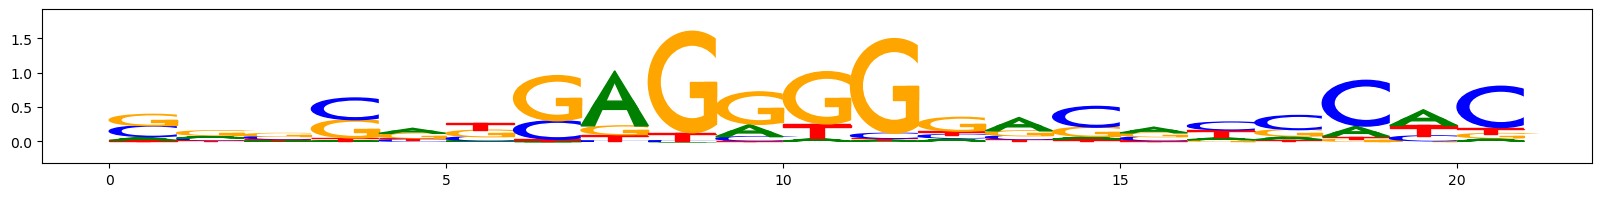

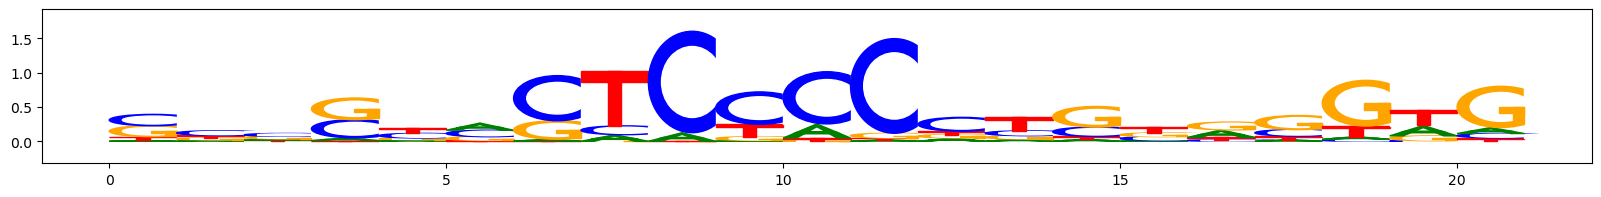

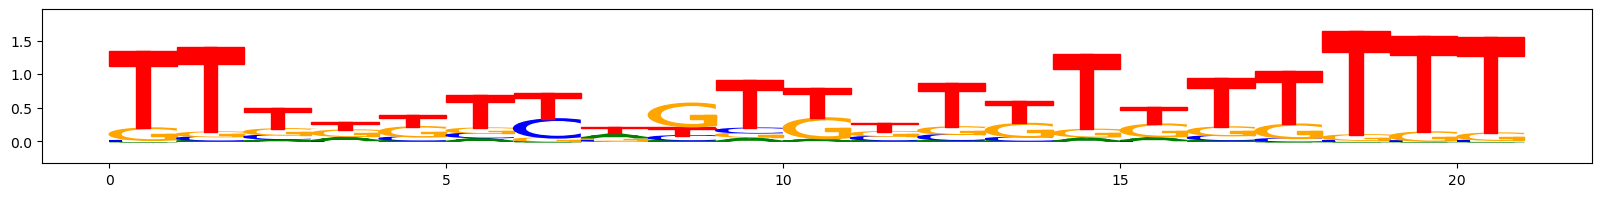

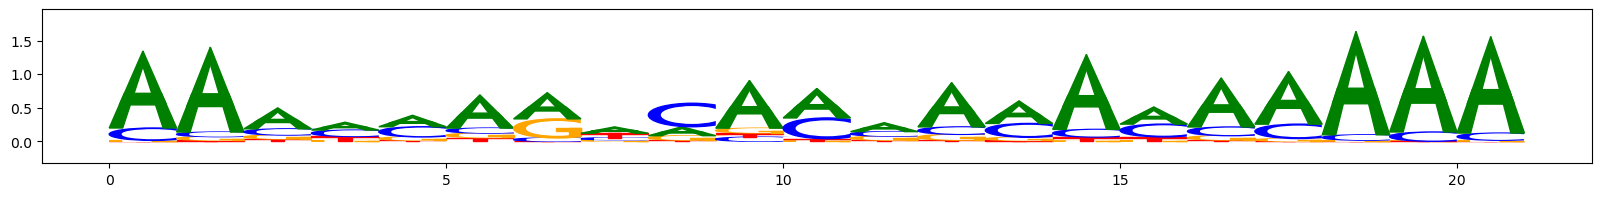

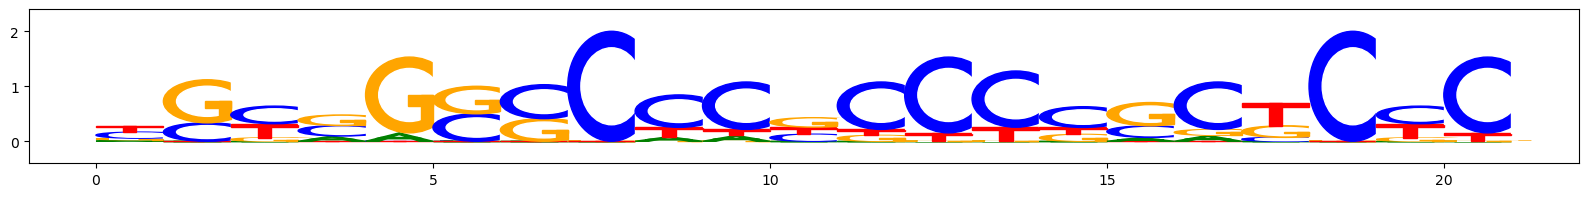

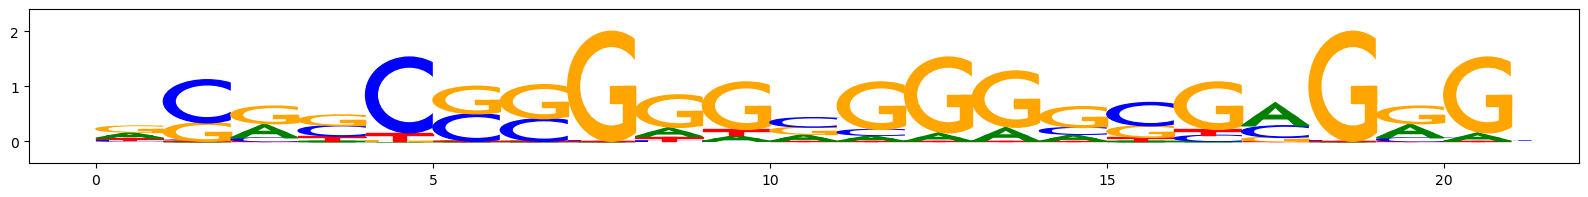

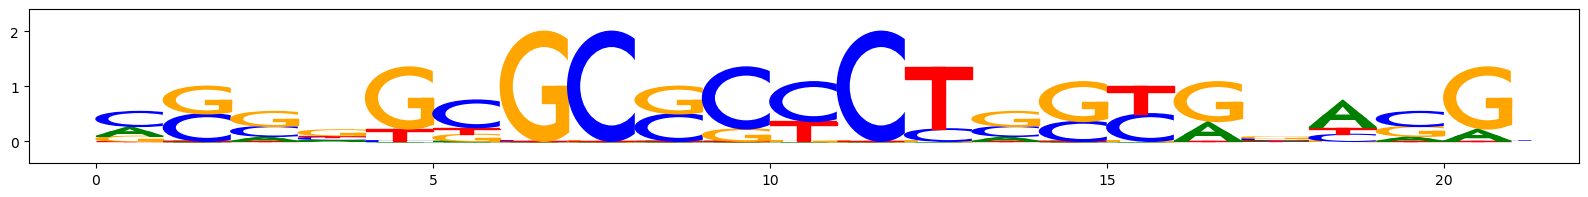

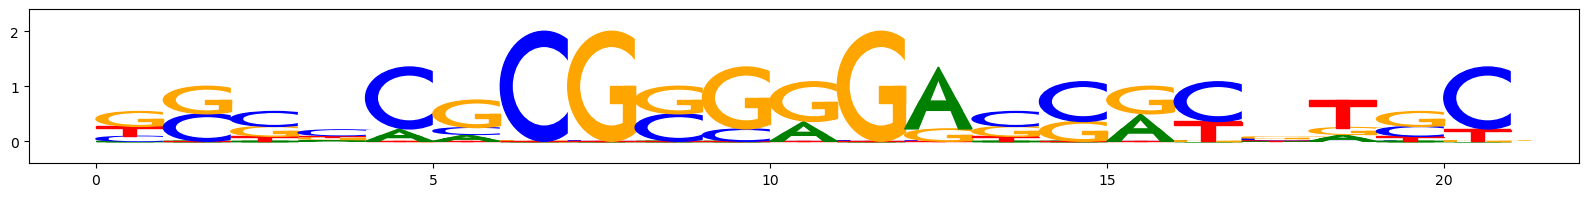

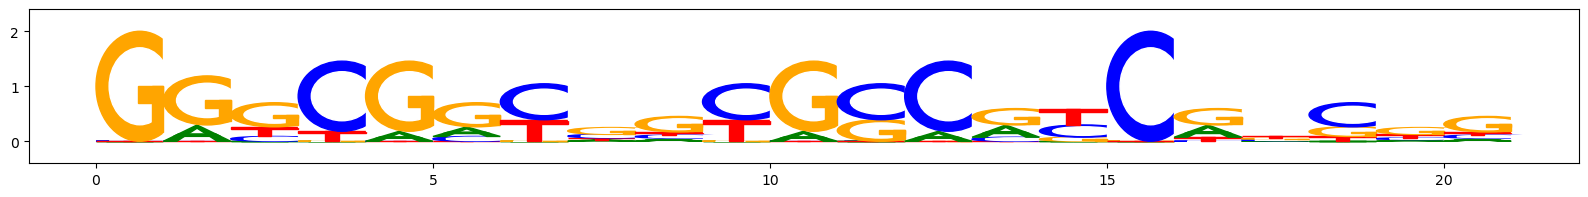

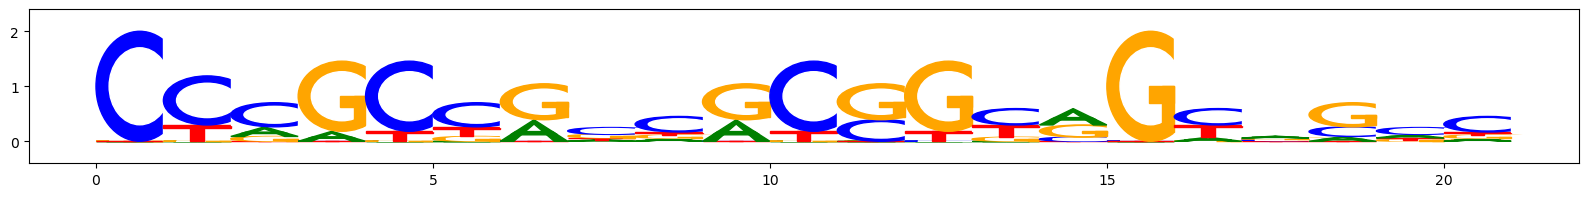

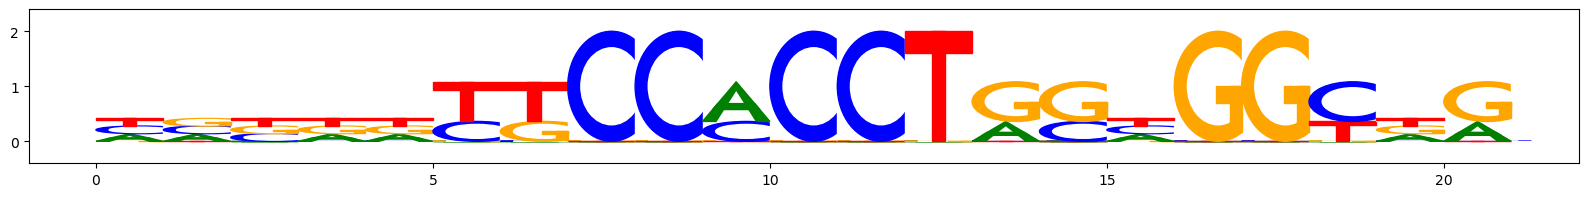

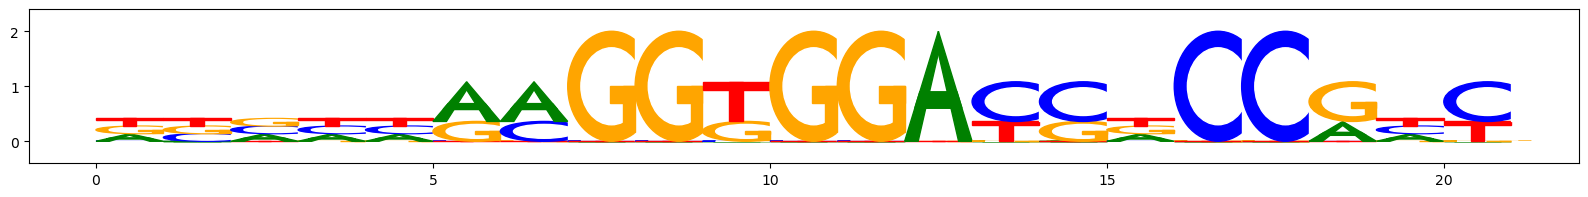

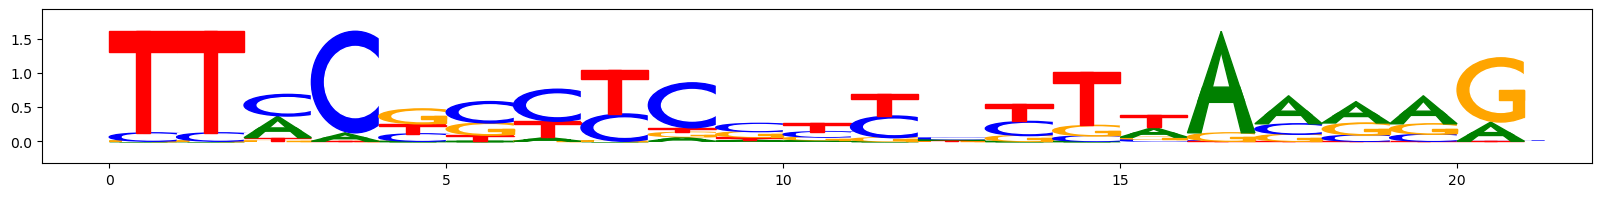

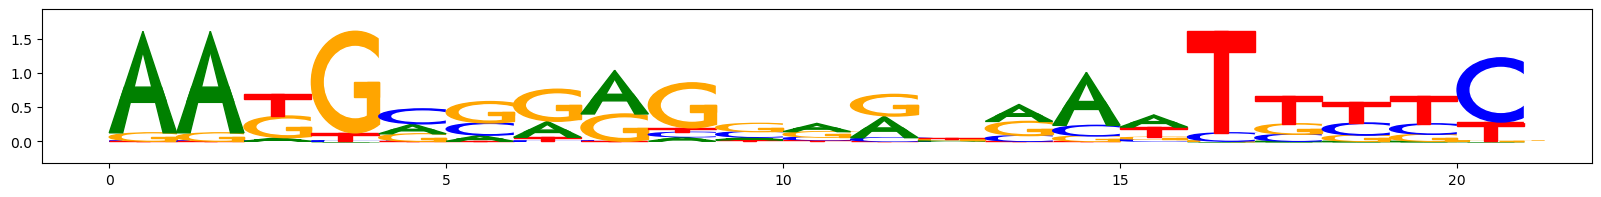

Out of the 128 filters 73 were never activated by the test sequences.


In [42]:
from deeplift.visualization import viz_sequence

nucleotides = ["A", "C", "G", "T"]

#For each filter remove sequences whose max activation is lesser than 70% of maximum activation of the filter
motifs = []
count_zero_ac_filter = 0
for i in range(first_conv.size(1)):
    max_seq = first_conv[:,i,:].max(dim=1).values
    keep_seq = max_seq > (0.7* max_activations[i])

    #Get subsequence where activation is maximal in each sequence
    if keep_seq.sum() > 0 :
        subseq = []
        for j,keep in enumerate(keep_seq):
            if keep:
                idx = first_conv[j,i,:].argmax().item()
                if (idx) >= 0 and (idx+first_kernel) < len(seq):
                    subseq.append(seq[j][(idx):(idx+first_kernel)])
        
        if subseq:
            #Count nucleotides occurrence at each position
            count_bp = []
            for h in range(len(subseq[0])):
                count_tmp = ["".join([x[h] for x in subseq]).count(n)/len(subseq) for n in nucleotides]
                count_bp.append(count_tmp)
            
            count_bp = np.transpose(np.array(count_bp))

            #Compute information content matrices
            IC_position = [np.log2(4) + np.sum(count_bp[:,j]*np.log2(count_bp[:,j]+0.0000001)) for j in range(count_bp.shape[1])]
            IC = count_bp * IC_position

            #Visualize inportance at each position of nucleotides
            viz_sequence.plot_weights(IC, subticks_frequency=5)

            #Visualize the reverse complement of the importance logo
            IC[[0,3],:] = IC[[3,0],:]
            IC[[1,2],:] = IC[[2,1],:]
            viz_sequence.plot_weights(IC, subticks_frequency=5)

            #Store motifs + reverse complement 
            motifs.append((("filter"+str(i)+"+"), np.transpose(count_bp)))
            
            reverse = count_bp.copy()
            reverse[[0,3],:] = reverse[[3,0],:]
            reverse[[1,2],:] = reverse[[2,1],:]
            motifs.append((("filter"+str(i)+"-"), np.transpose(reverse)))

    else:
        count_zero_ac_filter += 1

print("Out of the " + str(first_conv.size(1)) + " filters " + str(count_zero_ac_filter) + " were never activated by the test sequences.")

# Write motifs to MEME format 

In [45]:
import csv
#import iteround

with open("../results/128_first_filter.txt", "w") as text_file:
    
    #Write header
    text_file.write("MEME version 4 \n \nALPHABET= ACGT \n \nstrands: + - \n \n")
    text_file.write("Background letter frequencies \nA 0.25 C 0.25 G 0.25 T 0.25 \n \n")

    #Write each probability matrices
    for m in motifs:
        text_file.write("MOTIF " + m[0])
        text_file.write(f"\nletter-probability matrix: alength= 4 w= {first_kernel}\n")

        """ #Round the probability keeping sum to 1
        for i in range(m[1].shape[0]):
            m[1][i,:] = iteround.saferound(m[1][i,:], 4) """
        csv.writer(text_file, delimiter=' ').writerows(m[1])
        text_file.write("\n")

# Match motifs to known motifs wuing TOMTOM

In [46]:
!tomtom  -thres 0.05 -oc ../results/tomtom_out/ ../results/128_first_filter.txt ../data/JASPAR_motif.txt

/Applications/anaconda3/envs/LeKira/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Writing results to output directory '../results/tomtom_out/'.
Processing query 1 out of 108 
^C
